In [ ]:
import cv2
from PIL import Image
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import keras.layers as layers
# import tensorflow_addons as tfa

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization

In [ ]:
def create_landmark_channel(Xi, Yi, sigma=2):
    channel = np.zeros((256,256))
    for y in range(256):
        for x in range(256):
            channel[y,x] = np.exp(((x-Xi)**2 + (y-Yi)**2) / (-2* sigma**2))
    
    return channel

In [ ]:
train_inputImg = []
train_landmarks_coords = []

train_inputImg.append(pd.read_csv('../input/cephalometric-landmarks/train_senior.csv', delimiter=','))
train_inputImg.append(pd.read_csv('../input/cephalometric-landmarks/test1_senior.csv', delimiter=','))

sigma = 30
train_images = []
train_masks = []
count = 0
for csv_file in train_inputImg:
    for row in csv_file.values:
        count += 1
        img_landmarks = list(row)
        img_coords_list = []
        image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + img_landmarks[0], 0) / 255
        channels_list = []
        background_channel = np.zeros((256,256))
        
        for i in range(1,38,2):
            x = img_landmarks[i]
            y = img_landmarks[i+1]
            img_coords_list.append(x*256//1935)
            img_coords_list.append(y*256//2400)
            ch = create_landmark_channel(x*256//1935,y*256//2400, sigma)
            channels_list.append(ch)
            background_channel += ch
        
        train_landmarks_coords.append(np.array(img_coords_list))
        background_channel = 1 - background_channel
        channels_list.append(background_channel)
        mask = np.stack(channels_list, axis=-1)
        
        new_image = cv2.resize(image,(256,256))
        new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
        train_images.append(new_image)
        
        train_masks.append(mask)
        print(count)
        
train_images = np.stack(train_images, axis=0)
train_masks = np.stack(train_masks, axis=0)
train_landmarks_coords = np.array(train_landmarks_coords)
print(train_images.shape)
print(train_images[0].shape)
print(train_masks.shape)
print(train_masks[0].shape)
print(train_landmarks_coords.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
val_test_inputImg = pd.read_csv('../input/cephalometric-landmarks/test2_senior.csv', delimiter=',')

val_images = []
val_masks = []

test_images = []
test_masks = []

val_landmarks_coords = []
test_landmarks_coords = []

count = 1

for row in val_test_inputImg.values:
    img_landmarks = list(row)
    print(count)
    img_coords_list = []
    image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + img_landmarks[0], 0) / 255
    channels_list = []
    background_channel = np.zeros((256,256))
        
    for i in range(1,38,2):
        x = img_landmarks[i]
        y = img_landmarks[i+1]
        img_coords_list.append(x*256//1935)
        img_coords_list.append(y*256//2400)
        ch = create_landmark_channel(x*256//1935,y*256//2400, sigma)
        channels_list.append(ch)
        background_channel += ch
        
    background_channel = 1 - background_channel
    channels_list.append(background_channel)
    mask = np.stack(channels_list, axis=-1) 

    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    
    if count <= 50:
        val_images.append(new_image)
        val_masks.append(mask)
        val_landmarks_coords.append(np.array(img_coords_list))
    else:
        test_images.append(new_image)
        test_masks.append(mask)
        test_landmarks_coords.append(np.array(img_coords_list))
    count += 1
    
val_images = np.stack(val_images, axis=0)
val_masks = np.stack(val_masks, axis=0)
val_data = (val_images, val_masks)

test_images = np.stack(test_images, axis=0)
test_masks = np.stack(test_masks, axis=0)
val_landmarks_coords = np.array(val_landmarks_coords)
test_landmarks_coords = np.array(test_landmarks_coords)
print("Val images: ", val_images.shape)
print('Image: ', val_images[0].shape)
print('Val masks: ', val_masks.shape)
print('mask: ', val_masks[0].shape)
print('Test images: ', test_images.shape)
print('Image: ', test_images[0].shape)
print('Test masks: ', test_masks.shape)
print('mask: ', test_masks[0].shape)
print(val_landmarks_coords.shape)
print(test_landmarks_coords.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Val images:  (50, 256, 256, 1)
Image:  (256, 256, 1)
Val masks:  (50, 256, 256, 20)
mask:  (256, 256, 20)
Test images:  (50, 256, 256, 1)
Image:  (256, 256, 1)
Test masks:  (50, 256, 256, 20)
mask:  (256, 256, 20)
(50, 38)
(50, 38)


In [ ]:
np.save('train_images.npy', train_images)
np.save('train_masks_s30.npy', train_masks)
np.save('val_images.npy', val_images)
np.save('val_masks_s30.npy', val_masks)
np.save('test_images.npy', test_images)
np.save('test_masks_s30.npy', test_masks)

np.save('train_landmarks_coords.npy', train_landmarks_coords)
np.save('val_landmarks_coords.npy', val_landmarks_coords)
np.save('test_landmarks_coords.npy', test_landmarks_coords)

In [ ]:
train_images = np.load('Data/train_images.npy')
train_masks = np.load('Data/train_masks_s30.npy')
train_landmarks_coords = np.load('Data/train_landmarks_coords.npy')
train_pred_masks = np.load('Data/train_pred_masks.npy')

val_images = np.load('Data/val_images.npy')
val_masks = np.load('Data/val_masks_s30.npy')
val_landmarks_coords = np.load('Data/val_landmarks_coords.npy')
val_pred_masks = np.load('Data/val_pred_masks.npy')

test_images = np.load('Data/test_images.npy')
test_masks = np.load('Data/test_masks_s30.npy')
test_landmarks_coords = np.load('Data/test_landmarks_coords.npy')
test_pred_masks = np.load('Data/test_pred_masks.npy')

val_data = (val_images,val_masks)

In [ ]:
np.unique(train_landmarks_coords)

array([ 66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 242, 244, 245, 246], dtype=int64

In [ ]:
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(300, 256, 256, 1)
(300, 256, 256, 20)
(50, 256, 256, 1)
(50, 256, 256, 20)
(50, 256, 256, 1)
(50, 256, 256, 20)


In [ ]:
print(train_landmarks_coords.shape)
print(val_landmarks_coords.shape)
print(test_landmarks_coords.shape)

(300, 38)
(50, 38)
(50, 38)


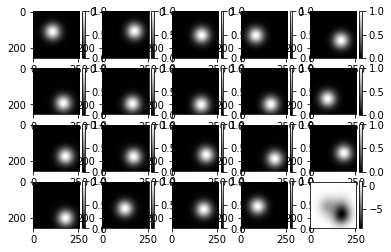

In [ ]:
test_mask_ex = test_masks[0]

# Visulaize all 20 channels
for i in range(20):
    channel = test_mask_ex[:,:,i]
    plt.subplot(4,5,i+1)
    plt.imshow(channel, cmap='gray')
    plt.colorbar()

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True, kernel_init='glorot_uniform'):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer=kernel_init)(inputs)
    
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer=kernel_init)(conv)
    conv = BatchNormalization()(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, output=False, kernel_init='glorot_uniform'):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer=kernel_init)(merge)
    conv = BatchNormalization()(conv)
        
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer=kernel_init)(conv)
    conv = BatchNormalization()(conv)
    
    if not output:
        conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer=kernel_init)(conv)
        conv = BatchNormalization()(conv)
    
    return conv

In [ ]:
def unet_model(input_size, n_filters=64, n_classes=2, kernel_init='glorot_uniform'):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters, kernel_init= kernel_init)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2, kernel_init=kernel_init)
    cblock3 = conv_block(cblock2[0], n_filters*4, kernel_init=kernel_init)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0, kernel_init=kernel_init) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False, kernel_init=kernel_init) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8, False, kernel_init=kernel_init)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4, False, kernel_init=kernel_init)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2, False, kernel_init=kernel_init)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters, True, kernel_init=kernel_init)

    #conv9 = Conv2D(n_filters,
    #             3,
    #             activation='relu',
    #             padding='same',
    #            kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size=1, activation='softmax', padding='same', kernel_initializer=kernel_init)(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
epsilon = 1e-7
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / ( K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)
    return dice

In [ ]:
def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    return 1 - dice

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
checkpoint_filepath = '/kaggle/working/checkpoint_Final_30sigma'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_dice_coeff',
    save_best_only=True)

In [ ]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# Adam_clr = tf.keras.optimizers.Adam(clr)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001)
Adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.001)
Adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [ ]:
kernel_init_HeNormal = tf.keras.initializers.HeNormal()
kernel_init_HeUniform = tf.keras.initializers.HeUniform()
kernel_init_RandomUniform = tf.keras.initializers.RandomUniform()
kernel_init_VarianceScaling = tf.keras.initializers.VarianceScaling()

In [ ]:
unet = unet_model((256,256,1), n_classes=20, kernel_init=kernel_init_HeNormal)

2022-12-30 14:45:36.277952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 14:45:36.475844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 14:45:36.476681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 14:45:36.478095: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
unet.compile(optimizer=Adam,
              loss=dice_loss,
              metrics=dice_coeff)

In [ ]:
model_history = unet.fit(train_images, train_masks, batch_size = 10, epochs=300, validation_data=val_data, callbacks=[reduce_lr, checkpoint])

2022-12-30 14:45:46.475895: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 78643200 exceeds 10% of free system memory.
2022-12-30 14:45:48.107030: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-12-30 14:45:49.977461: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 78643200 exceeds 10% of free system memory.
2022-12-30 14:45:49.993105: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-12-30 14:45:51.381279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-12-30 14:45:53.994101: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 52428800 exceeds 10% of free system memory.
2022-12-30 14:45:54.990451: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


30/30 [==============================] - 27s 433ms/step - loss: 0.5536 - dice_coeff: 0.4464 - val_loss: 1.7101 - val_dice_coeff: -0.7101


2022-12-30 14:46:22.029419: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/300
30/30 [==============================] - 12s 399ms/step - loss: 0.4003 - dice_coeff: 0.5997 - val_loss: 0.8551 - val_dice_coeff: 0.1449
Epoch 3/300
30/30 [==============================] - 12s 395ms/step - loss: 0.3477 - dice_coeff: 0.6523 - val_loss: 0.8575 - val_dice_coeff: 0.1425
Epoch 4/300
30/30 [==============================] - 11s 377ms/step - loss: 0.3053 - dice_coeff: 0.6947 - val_loss: 0.8237 - val_dice_coeff: 0.1763
Epoch 5/300
30/30 [==============================] - 11s 375ms/step - loss: 0.2846 - dice_coeff: 0.7154 - val_loss: 0.7789 - val_dice_coeff: 0.2211
Epoch 6/300
30/30 [==============================] - 12s 396ms/step - loss: 0.2737 - dice_coeff: 0.7263 - val_loss: 0.6745 - val_dice_coeff: 0.3255
Epoch 7/300
30/30 [==============================] - 11s 379ms/step - loss: 0.2681 - dice_coeff: 0.7319 - val_loss: 0.5954 - val_dice_coeff: 0.4046
Epoch 8/300
30/30 [==============================] - 12s 397ms/step - loss: 0.2668 - dice_coeff: 0.7332 - val_lo

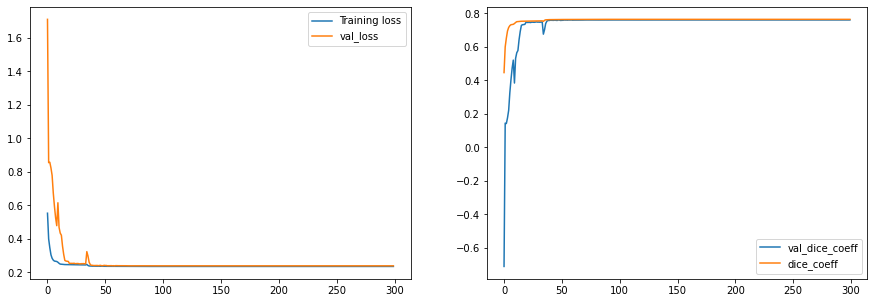

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(model_history.history['loss'])
ax1.plot(model_history.history['val_loss'])
ax1.legend(['Training loss', 'val_loss'])

ax2.plot(model_history.history['val_dice_coeff'])
ax2.plot(model_history.history['dice_coeff'])
ax2.legend(['val_dice_coeff', 'dice_coeff'])

In [ ]:
unet.evaluate(test_images, test_masks)

2/2 [==============================] - 14s 5s/step - loss: 0.2427 - dice_coeff: 0.7575


[0.2426551878452301, 0.757546603679657]

In [ ]:
test_pred_masks = unet.predict(test_images)
train_pred_masks = unet.predict(train_images)

In [ ]:
print(test_pred_masks.shape)
print(train_pred_masks.shape)

(50, 256, 256, 20)
(300, 256, 256, 20)


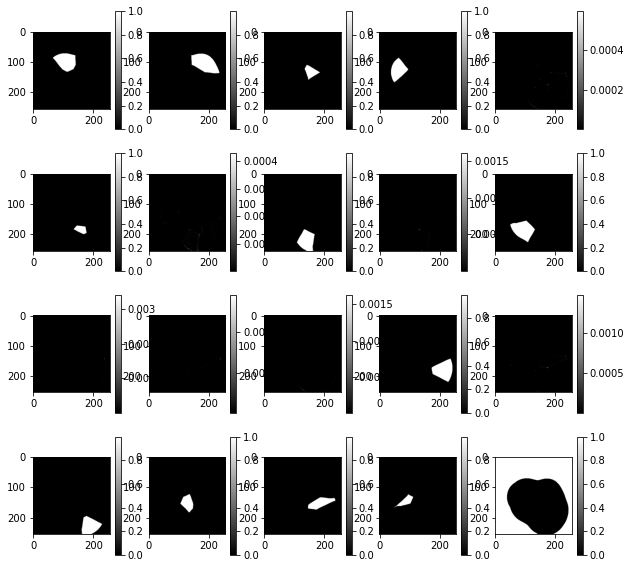

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
t_mask = test_pred_masks[0]

# Visulaize all 20 channels
for i in range(20):
    channel = t_mask[:,:,i]
    plt.subplot(4,5,i+1)
    plt.imshow(channel, cmap='gray')
    plt.colorbar()

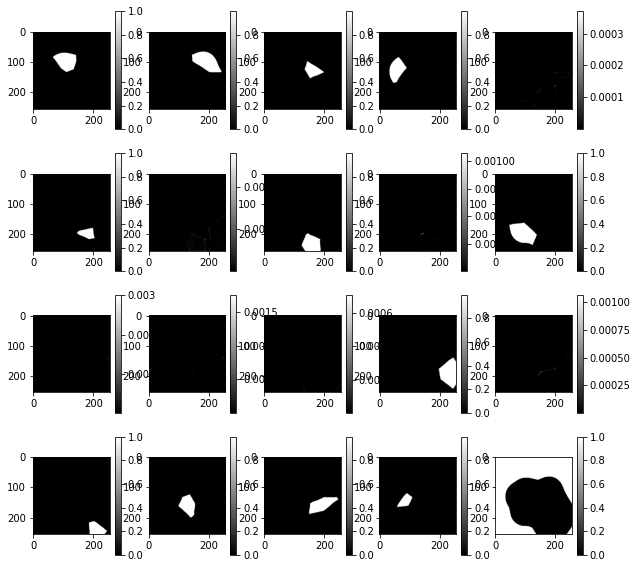

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
tr_mask = train_pred_masks[0]

# Visulaize all 20 channels
for i in range(20):
    channel = tr_mask[:,:,i]
    plt.subplot(4,5,i+1)
    plt.imshow(channel, cmap='gray')
    plt.colorbar()

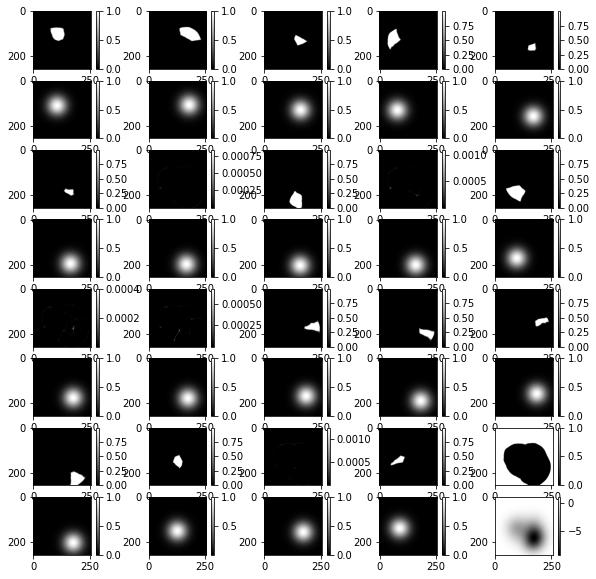

In [ ]:
mask = test_pred_masks[0]
test_mask_ex = test_masks[0]

# Visulaize all 20 channels
for i in range(20):
    if i <= 4:
        j = i
    elif i >= 5 and i <=9:
        j = i + 5
    elif i >= 10 and i <= 14:
        j = i + 10
    elif i >= 15 and i <=19:
        j = i + 15
    
    pred_channel = mask[:,:,i]
    test_channel = test_mask_ex[:,:,i]
    plt.subplot(8,5,j+1)
    plt.imshow(pred_channel, cmap='gray')
    plt.colorbar()
    plt.subplot(8,5,j+1+5)
    plt.imshow(test_channel, cmap='gray')
    plt.colorbar()

In [ ]:
print(np.max(mask[:,:,0]))
print(np.min(mask[:,:,0]))

1.0
1.5142503e-13


In [ ]:
# As an example: find L5 x and y locations for first image in test set for comparison
test_mask1_L1 = test_masks[0][:,:,4]
pred_mask1_L1 = test_pred_masks[0][:,:,4]

max_prob_test = np.max(test_mask1_L1)
max_prob_pred = np.max(pred_mask1_L1)

true_x, true_y = np.where(test_mask1_L1 == max_prob_test)
pred_x, pred_y = np.where(pred_mask1_L1 == max_prob_pred)
print('True x: ',true_x, '  True y: ', true_y)
print('Pred x: ',pred_x, '  Pred y: ', pred_y)

# Calculate Mean Radial Error
# take average of predictions
pred_x_avg = np.average(pred_x)
pred_y_avg = np.average(pred_y)

MRE_x = (abs(pred_x_avg - true_x) * (0.1*1935/256))[0]
MRE_y = (abs(pred_y_avg - true_y) * (0.1*2400/256))[0] 

print('MRE x: ', MRE_x)
print('MRE y: ', MRE_y)

True x:  [159]   True y:  [169]
Pred x:  [136]   Pred y:  [234]
MRE x:  17.384765625
MRE y:  60.9375


In [ ]:
def findMRE(test_mask, pred_mask):
    image_MRE = []
    image_MRE_x = []
    image_MRE_y = []
    for i in range(19):   # landmarks channels
        test_landmark_channel = test_mask[:,:,i]
        pred_landmark_channel = pred_mask[:,:,i]
        
        max_prob_test = np.max(test_landmark_channel)
        max_prob_pred = np.max(pred_landmark_channel)
        
        true_x, true_y = np.where(test_landmark_channel == max_prob_test)
        pred_x, pred_y = np.where(pred_landmark_channel == max_prob_pred)
        
        pred_x_avg = np.average(pred_x)
        pred_y_avg = np.average(pred_y)

        MRE_x = (abs(pred_x_avg - true_x) * (0.1*1935/256))[0]
        MRE_y = (abs(pred_y_avg - true_y) * (0.1*2400/256))[0] 
        MRE = np.sqrt(MRE_x**2 + MRE_y**2)
        
        image_MRE_x.append(MRE_x)
        image_MRE_y.append(MRE_y)
        image_MRE.append(MRE)
    return image_MRE_x, image_MRE_y, image_MRE

In [ ]:
boxplot_data_x = []
boxplot_data_y = []
boxplot_data = []
for i in range(50):
    image_MRE_x, image_MRE_y, image_MRE = findMRE(test_masks[i], test_pred_masks[i])
    boxplot_data_x.append(image_MRE_x)
    boxplot_data_y.append(image_MRE_y)
    boxplot_data.append(image_MRE)
    
boxplot_data_x = np.array(boxplot_data_x)
boxplot_data_y = np.array(boxplot_data_y)
boxplot_data = np.array(boxplot_data)

<AxesSubplot:>

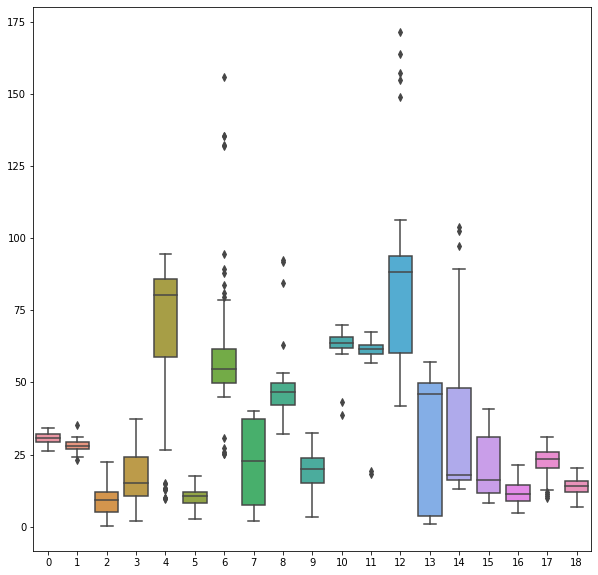

In [ ]:
sns.boxplot(data=boxplot_data)  # Pythagoras

<AxesSubplot:>

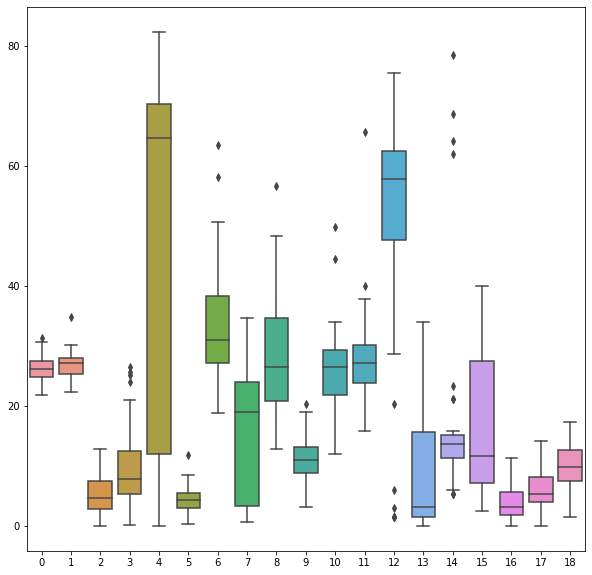

In [ ]:
sns.boxplot(data=boxplot_data_x)  # x

<AxesSubplot:>

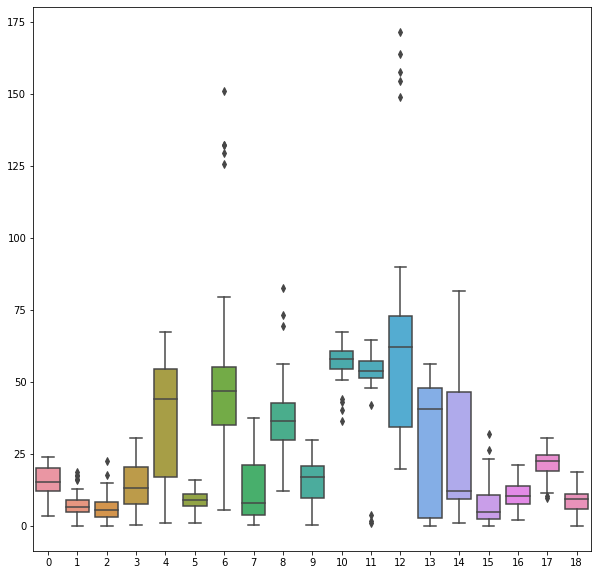

In [ ]:
sns.boxplot(data=boxplot_data_y)  # y

# Make ROIs ready for Resnet

In [ ]:
val_pred_masks = unet.predict(val_images)

In [ ]:
np.save('val_pred_masks.npy', val_pred_masks)

In [ ]:
np.save('test_pred_masks.npy', test_pred_masks)
np.save('train_pred_masks.npy', train_pred_masks)

In [ ]:
print(test_pred_masks.shape)
print(train_pred_masks.shape)

(50, 256, 256, 20)
(300, 256, 256, 20)


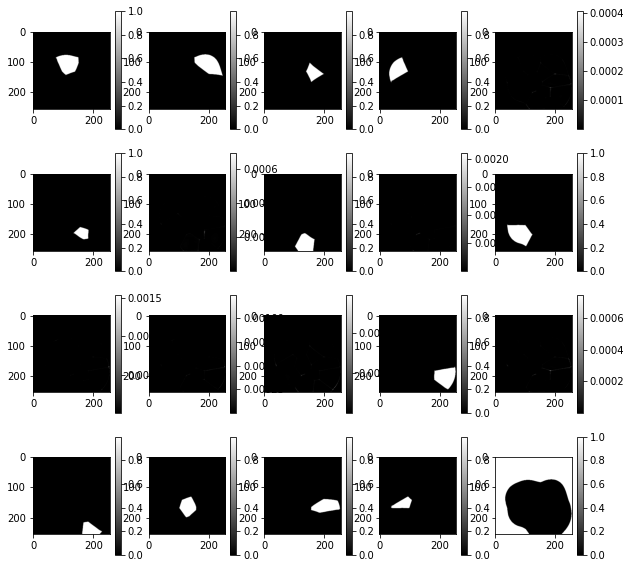

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
t_mask = test_pred_masks[46]

# Visulaize all 20 channels
for i in range(20):
    channel = t_mask[:,:,i]
    plt.subplot(4,5,i+1)
    plt.imshow(channel, cmap='gray')
    plt.colorbar()

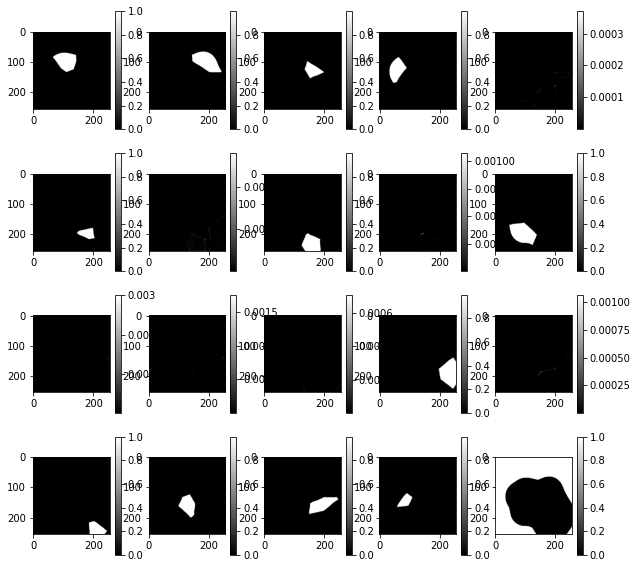

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
tr_mask = train_pred_masks[0]

# Visulaize all 20 channels
for i in range(20):
    channel = tr_mask[:,:,i]
    plt.subplot(4,5,i+1)
    plt.imshow(channel, cmap='gray')
    plt.colorbar()

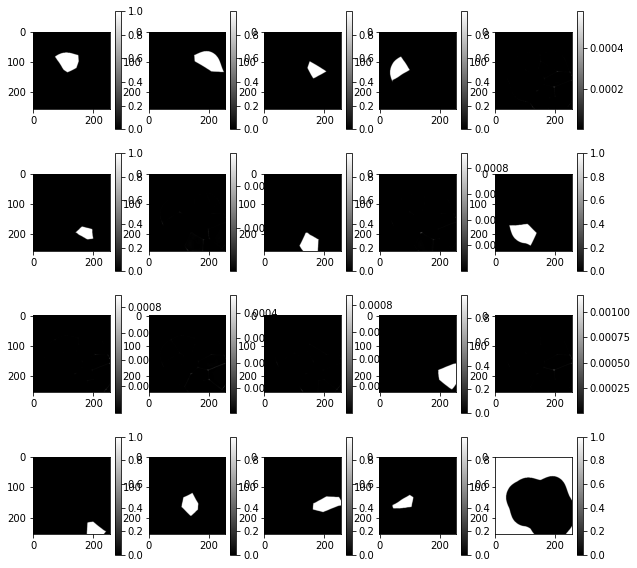

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
v_mask = val_pred_masks[0]

# Visulaize all 20 channels
for i in range(20):
    channel = v_mask[:,:,i]
    plt.subplot(4,5,i+1)
    plt.imshow(channel, cmap='gray')
    plt.colorbar()

In [ ]:
train_ROIs = np.zeros((19,300,120,120,3))
x_newtrue_list = np.zeros((19,300), dtype=int)
y_newtrue_list = np.zeros((19,300), dtype=int)
errors = []
count = 0
for train_image, train_mask, true_coords in zip(train_images, train_pred_masks, train_landmarks_coords):
    print("Image: ", count+1)
    x_coords_list = []
    y_coords_list = []
    black_channels = []
    for i,j in zip(range(19),range(0,38,2)):
        channel = train_mask[:,:,i]
        max_prob = np.max(channel)
        
        if max_prob > 0.1:                 # white channel
            print("White Channel: ", i)
            y_coords, x_coords = np.where(channel == max_prob)
            x_coord = int(np.average(x_coords))
            y_coord = int(np.average(y_coords))   

            if y_coord+60 > 256:
                y_coord = 256 - 60

            elif y_coord-60 < 0:
                y_coord = 60
                
            if x_coord+60 > 256:
                x_coord = 256 - 60

            elif x_coord-60 < 0:
                x_coord = 60
            
            x_coords_list.append([i,x_coord])
            y_coords_list.append([i,y_coord])
            
            col_start = x_coord - 60
            row_start = y_coord - 60
            col_end = x_coord + 60
            row_end = y_coord + 60
            print("X Coord", x_coord)
            print("Y Coord", y_coord)
            ROI = train_image[row_start:row_end, col_start:col_end, :]
            
            x_true = true_coords[j]
            y_true = true_coords[j+1]
            print("X true: ", x_true)
            print("Y true: ", y_true)
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            if (new_x_true < 0) or (new_x_true > 120) or (new_y_true < 0) or (new_y_true > 120):
#                 raise ValueError("Error: {}  ,{}".format(new_x_true,new_y_true))
                print("#################### Error")
                print(new_x_true, "  ",new_y_true)
                errors.append(i)
                
            train_ROIs[i][count] = np.repeat(ROI, 3, axis=-1)
            print("new X true: ", new_x_true)
            print("new Y true: ", new_y_true)
            x_newtrue_list[i][count] = new_x_true
            y_newtrue_list[i][count] = new_y_true

        else:                             # black channel
            black_channels.append(i)
        
    for black_chlidx in black_channels:
        print("Black Channel: ", black_chlidx)
        
        if black_chlidx == 4:                                   # L5  ---> take ROI of L18
            train_ROIs[black_chlidx][count] = train_ROIs[17][count]
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[10][1]
            y_coord = y_coords_list[10][1]
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            x_newtrue_list[black_chlidx][count] = new_x_true
            y_newtrue_list[black_chlidx][count] = new_y_true
        
        elif black_chlidx == 6 or black_chlidx == 8:           # L7 and L9  ---> take ROI of L8 + shift right 20
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[5][1] + 20
            y_coord = y_coords_list[5][1] 
            
            if x_coord+60 > 256:
                x_coord = 256 - 60
                
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            x_newtrue_list[black_chlidx][count] = new_x_true
            y_newtrue_list[black_chlidx][count] = new_y_true
            
            col_start = x_coord - 60
            row_start = y_coord - 60
            col_end = x_coord + 60
            row_end = y_coord + 60
            ROI = train_image[row_start:row_end, col_start:col_end, :]
            train_ROIs[black_chlidx][count] = np.repeat(ROI, 3, axis=-1)
        
        elif black_chlidx == 10 or black_chlidx == 11 or black_chlidx == 12 or black_chlidx == 14:  #l11,12,13,15 ---> take ROI of l14
            train_ROIs[black_chlidx][count] = train_ROIs[13][count]
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[7][1]
            y_coord = y_coords_list[7][1]
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            x_newtrue_list[black_chlidx][count] = new_x_true
            y_newtrue_list[black_chlidx][count] = new_y_true
    
            
    count += 1

Image:  1
White Channel:  0
X Coord 77
Y Coord 77
X true:  106
Y true:  109
new X true:  89
new Y true:  92
White Channel:  1
X Coord 196
Y Coord 71
X true:  183
Y true:  103
new X true:  47
new Y true:  92
White Channel:  2
X Coord 171
Y Coord 124
X true:  166
Y true:  129
new X true:  55
new Y true:  65
White Channel:  3
X Coord 66
Y Coord 134
X true:  78
Y true:  129
new X true:  72
new Y true:  55
White Channel:  5
X Coord 180
Y Coord 196
X true:  190
Y true:  202
new X true:  70
new Y true:  66
White Channel:  7
X Coord 184
Y Coord 196
X true:  179
Y true:  228
new X true:  55
new Y true:  92
White Channel:  9
X Coord 75
Y Coord 169
X true:  92
Y true:  191
new X true:  77
new Y true:  82
White Channel:  13
X Coord 196
Y Coord 161
X true:  213
Y true:  200
new X true:  77
new Y true:  99
White Channel:  15
X Coord 196
Y Coord 196
X true:  194
Y true:  227
new X true:  58
new Y true:  91
White Channel:  16
X Coord 141
Y Coord 148
X true:  126
Y true:  154
new X true:  45
new Y true

White Channel:  7
X Coord 137
Y Coord 196
X true:  173
Y true:  223
new X true:  96
new Y true:  87
White Channel:  9
X Coord 76
Y Coord 173
X true:  95
Y true:  190
new X true:  79
new Y true:  77
White Channel:  13
X Coord 196
Y Coord 156
X true:  212
Y true:  195
new X true:  76
new Y true:  99
White Channel:  15
X Coord 196
Y Coord 196
X true:  190
Y true:  221
new X true:  54
new Y true:  85
White Channel:  16
X Coord 135
Y Coord 148
X true:  128
Y true:  154
new X true:  53
new Y true:  66
White Channel:  17
X Coord 164
Y Coord 163
X true:  186
Y true:  152
new X true:  82
new Y true:  49
White Channel:  18
X Coord 97
Y Coord 159
X true:  87
Y true:  145
new X true:  50
new Y true:  46
Black Channel:  4
Black Channel:  6
***********X Coord 157
***********Y Coord 196
Black Channel:  8
***********X Coord 157
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  9
White Channel:  0
X Coord 89
Y Coord 76
X true:  108
Y true:  115
n

X Coord 178
Y Coord 196
X true:  169
Y true:  225
new X true:  51
new Y true:  89
White Channel:  16
X Coord 136
Y Coord 144
X true:  119
Y true:  152
new X true:  43
new Y true:  68
White Channel:  17
X Coord 152
Y Coord 162
X true:  178
Y true:  154
new X true:  86
new Y true:  52
White Channel:  18
X Coord 88
Y Coord 157
X true:  80
Y true:  142
new X true:  52
new Y true:  45
Black Channel:  4
Black Channel:  6
***********X Coord 144
***********Y Coord 196
Black Channel:  8
***********X Coord 144
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  16
White Channel:  0
X Coord 86
Y Coord 73
X true:  103
Y true:  108
new X true:  77
new Y true:  95
White Channel:  1
X Coord 180
Y Coord 60
X true:  177
Y true:  97
new X true:  57
new Y true:  97
White Channel:  2
X Coord 164
Y Coord 130
X true:  166
Y true:  123
new X true:  62
new Y true:  53
White Channel:  3
X Coord 65
Y Coord 140
X true:  81
Y true:  129
new X true:  76
new Y 

new X true:  69
new Y true:  63
White Channel:  7
X Coord 137
Y Coord 196
X true:  159
Y true:  205
new X true:  82
new Y true:  69
White Channel:  9
X Coord 91
Y Coord 165
X true:  100
Y true:  176
new X true:  69
new Y true:  71
White Channel:  13
X Coord 196
Y Coord 188
X true:  191
Y true:  189
new X true:  55
new Y true:  61
White Channel:  15
X Coord 184
Y Coord 196
X true:  173
Y true:  210
new X true:  49
new Y true:  74
White Channel:  16
X Coord 131
Y Coord 152
X true:  124
Y true:  152
new X true:  53
new Y true:  60
White Channel:  17
X Coord 156
Y Coord 162
X true:  176
Y true:  151
new X true:  80
new Y true:  49
White Channel:  18
X Coord 96
Y Coord 153
X true:  88
Y true:  145
new X true:  52
new Y true:  52
Black Channel:  4
Black Channel:  6
***********X Coord 157
***********Y Coord 196
Black Channel:  8
***********X Coord 157
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  24
White Channel:  0
X Coord 93
Y Co

new X true:  50
new Y true:  65
White Channel:  13
X Coord 196
Y Coord 196
X true:  194
Y true:  195
new X true:  58
new Y true:  59
White Channel:  15
X Coord 194
Y Coord 196
X true:  182
Y true:  220
new X true:  48
new Y true:  84
White Channel:  16
X Coord 134
Y Coord 158
X true:  122
Y true:  161
new X true:  48
new Y true:  63
White Channel:  17
X Coord 163
Y Coord 160
X true:  177
Y true:  159
new X true:  74
new Y true:  59
White Channel:  18
X Coord 90
Y Coord 157
X true:  84
Y true:  139
new X true:  54
new Y true:  42
Black Channel:  4
Black Channel:  6
***********X Coord 157
***********Y Coord 196
Black Channel:  8
***********X Coord 157
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  31
White Channel:  0
X Coord 101
Y Coord 81
X true:  110
Y true:  119
new X true:  69
new Y true:  98
White Channel:  1
X Coord 182
Y Coord 74
X true:  186
Y true:  110
new X true:  64
new Y true:  96
White Channel:  2
X Coord 179
Y Co

new X true:  85
new Y true:  48
White Channel:  18
X Coord 90
Y Coord 168
X true:  89
Y true:  145
new X true:  59
new Y true:  37
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  38
White Channel:  0
X Coord 89
Y Coord 76
X true:  110
Y true:  111
new X true:  81
new Y true:  95
White Channel:  1
X Coord 179
Y Coord 64
X true:  178
Y true:  101
new X true:  59
new Y true:  97
White Channel:  2
X Coord 154
Y Coord 128
X true:  167
Y true:  128
new X true:  73
new Y true:  60
White Channel:  3
X Coord 66
Y Coord 135
X true:  77
Y true:  132
new X true:  71
new Y true:  57
White Channel:  5
X Coord 182
Y Coord 186
X true:  186
Y true:  186
new X true:  64
new Y true:  60
White Channel:  7
X Coord 173
Y Coord 196
X true:  178
Y true:  202
new X true:  65
new Y true:  66
White Channel:  9
X Coord 72
Y Coord 173


White Channel:  13
X Coord 196
Y Coord 167
X true:  210
Y true:  189
new X true:  74
new Y true:  82
White Channel:  15
X Coord 196
Y Coord 196
X true:  198
Y true:  221
new X true:  62
new Y true:  85
White Channel:  16
X Coord 131
Y Coord 143
X true:  121
Y true:  146
new X true:  50
new Y true:  63
White Channel:  17
X Coord 156
Y Coord 160
X true:  183
Y true:  151
new X true:  87
new Y true:  51
White Channel:  18
X Coord 88
Y Coord 153
X true:  81
Y true:  133
new X true:  53
new Y true:  40
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  46
White Channel:  0
X Coord 92
Y Coord 79
X true:  109
Y true:  113
new X true:  77
new Y true:  94
White Channel:  1
X Coord 170
Y Coord 70
X true:  185
Y true:  104
new X true:  75
new Y true:  94
White Channel:  2
X Coord 179
Y Coord 135
X true:  173
Y true:  130

new X true:  47
new Y true:  83
White Channel:  15
X Coord 177
Y Coord 196
X true:  175
Y true:  223
new X true:  58
new Y true:  87
White Channel:  16
X Coord 128
Y Coord 142
X true:  116
Y true:  151
new X true:  48
new Y true:  69
White Channel:  17
X Coord 146
Y Coord 173
X true:  171
Y true:  159
new X true:  85
new Y true:  46
White Channel:  18
X Coord 80
Y Coord 153
X true:  75
Y true:  132
new X true:  55
new Y true:  39
Black Channel:  4
Black Channel:  6
***********X Coord 139
***********Y Coord 196
Black Channel:  8
***********X Coord 139
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  53
White Channel:  0
X Coord 84
Y Coord 79
X true:  104
Y true:  113
new X true:  80
new Y true:  94
White Channel:  1
X Coord 192
Y Coord 77
X true:  179
Y true:  110
new X true:  47
new Y true:  93
White Channel:  2
X Coord 161
Y Coord 142
X true:  163
Y true:  137
new X true:  62
new Y true:  55
White Channel:  3
X Coord 64
Y Coord

Y Coord 155
X true:  134
Y true:  160
new X true:  45
new Y true:  65
White Channel:  17
X Coord 174
Y Coord 171
X true:  197
Y true:  158
new X true:  83
new Y true:  47
White Channel:  18
X Coord 108
Y Coord 149
X true:  93
Y true:  140
new X true:  45
new Y true:  51
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  60
White Channel:  0
X Coord 78
Y Coord 74
X true:  99
Y true:  109
new X true:  81
new Y true:  95
White Channel:  1
X Coord 171
Y Coord 69
X true:  172
Y true:  104
new X true:  61
new Y true:  95
White Channel:  2
X Coord 175
Y Coord 128
X true:  160
Y true:  129
new X true:  45
new Y true:  61
White Channel:  3
X Coord 60
Y Coord 130
X true:  74
Y true:  123
new X true:  74
new Y true:  53
White Channel:  5
X Coord 166
Y Coord 196
X true:  177
Y true:  197
new X true:  71
new Y true:  61
Wh

new X true:  74
new Y true:  96
White Channel:  1
X Coord 179
Y Coord 63
X true:  176
Y true:  98
new X true:  57
new Y true:  95
White Channel:  2
X Coord 168
Y Coord 122
X true:  165
Y true:  129
new X true:  57
new Y true:  67
White Channel:  3
X Coord 72
Y Coord 142
X true:  83
Y true:  130
new X true:  71
new Y true:  48
White Channel:  5
X Coord 176
Y Coord 196
X true:  187
Y true:  192
new X true:  71
new Y true:  56
White Channel:  7
X Coord 184
Y Coord 196
X true:  188
Y true:  218
new X true:  64
new Y true:  82
White Channel:  9
X Coord 139
Y Coord 196
X true:  115
Y true:  186
new X true:  36
new Y true:  50
White Channel:  13
X Coord 196
Y Coord 180
X true:  202
Y true:  185
new X true:  66
new Y true:  65
White Channel:  15
X Coord 196
Y Coord 196
X true:  199
Y true:  217
new X true:  63
new Y true:  81
White Channel:  16
X Coord 140
Y Coord 154
X true:  127
Y true:  155
new X true:  47
new Y true:  61
White Channel:  17
X Coord 159
Y Coord 164
X true:  179
Y true:  153


X Coord 60
Y Coord 151
X true:  82
Y true:  135
new X true:  82
new Y true:  44
White Channel:  5
X Coord 173
Y Coord 191
X true:  187
Y true:  192
new X true:  74
new Y true:  61
White Channel:  7
X Coord 176
Y Coord 196
X true:  181
Y true:  213
new X true:  65
new Y true:  77
White Channel:  9
X Coord 79
Y Coord 170
X true:  97
Y true:  186
new X true:  78
new Y true:  76
White Channel:  13
X Coord 196
Y Coord 196
X true:  208
Y true:  195
new X true:  72
new Y true:  59
White Channel:  15
X Coord 196
Y Coord 196
X true:  197
Y true:  216
new X true:  61
new Y true:  80
White Channel:  16
X Coord 138
Y Coord 159
X true:  133
Y true:  151
new X true:  55
new Y true:  52
White Channel:  17
X Coord 171
Y Coord 166
X true:  192
Y true:  153
new X true:  81
new Y true:  47
White Channel:  18
X Coord 98
Y Coord 156
X true:  89
Y true:  142
new X true:  51
new Y true:  46
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 

new X true:  38
new Y true:  64
White Channel:  15
X Coord 182
Y Coord 196
X true:  155
Y true:  217
new X true:  33
new Y true:  81
White Channel:  16
X Coord 126
Y Coord 152
X true:  110
Y true:  154
new X true:  44
new Y true:  62
White Channel:  17
X Coord 144
Y Coord 166
X true:  166
Y true:  158
new X true:  82
new Y true:  52
White Channel:  18
X Coord 80
Y Coord 157
X true:  78
Y true:  144
new X true:  58
new Y true:  47
Black Channel:  4
Black Channel:  6
***********X Coord 144
***********Y Coord 196
Black Channel:  8
***********X Coord 144
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  83
White Channel:  0
X Coord 79
Y Coord 69
X true:  97
Y true:  103
new X true:  78
new Y true:  94
White Channel:  1
X Coord 156
Y Coord 60
X true:  164
Y true:  92
new X true:  68
new Y true:  92
White Channel:  2
X Coord 150
Y Coord 126
X true:  153
Y true:  122
new X true:  63
new Y true:  56
White Channel:  3
X Coord 60
Y Coord 1

X Coord 196
Y Coord 196
X true:  215
Y true:  199
new X true:  79
new Y true:  63
White Channel:  15
X Coord 196
Y Coord 196
X true:  201
Y true:  224
new X true:  65
new Y true:  88
White Channel:  16
X Coord 148
Y Coord 158
X true:  142
Y true:  154
new X true:  54
new Y true:  56
White Channel:  17
X Coord 183
Y Coord 165
X true:  203
Y true:  156
new X true:  80
new Y true:  51
White Channel:  18
X Coord 109
Y Coord 161
X true:  93
Y true:  147
new X true:  44
new Y true:  46
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  90
White Channel:  0
X Coord 93
Y Coord 76
X true:  109
Y true:  112
new X true:  76
new Y true:  96
White Channel:  1
X Coord 185
Y Coord 72
X true:  188
Y true:  108
new X true:  63
new Y true:  96
White Channel:  2
X Coord 162
Y Coord 136
X true:  170
Y true:  135
new X true:  68
n

White Channel:  18
X Coord 104
Y Coord 161
X true:  96
Y true:  143
new X true:  52
new Y true:  42
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  97
White Channel:  0
X Coord 89
Y Coord 74
X true:  115
Y true:  103
new X true:  86
new Y true:  89
White Channel:  1
X Coord 196
Y Coord 66
X true:  194
Y true:  99
new X true:  58
new Y true:  93
White Channel:  2
X Coord 164
Y Coord 114
X true:  173
Y true:  126
new X true:  69
new Y true:  72
White Channel:  3
X Coord 73
Y Coord 138
X true:  87
Y true:  130
new X true:  74
new Y true:  52
White Channel:  5
X Coord 190
Y Coord 196
X true:  199
Y true:  200
new X true:  69
new Y true:  64
White Channel:  7
X Coord 187
Y Coord 196
X true:  189
Y true:  225
new X true:  62
new Y true:  89
White Channel:  9
X Coord 82
Y Coord 179
X true:  111
Y true:  196
new X 

new X true:  70
new Y true:  96
White Channel:  2
X Coord 173
Y Coord 134
X true:  175
Y true:  142
new X true:  62
new Y true:  68
White Channel:  3
X Coord 70
Y Coord 132
X true:  84
Y true:  129
new X true:  74
new Y true:  57
White Channel:  5
X Coord 163
Y Coord 196
X true:  176
Y true:  203
new X true:  73
new Y true:  67
White Channel:  7
X Coord 133
Y Coord 196
X true:  168
Y true:  222
new X true:  95
new Y true:  86
White Channel:  9
X Coord 71
Y Coord 171
X true:  85
Y true:  191
new X true:  74
new Y true:  80
White Channel:  13
X Coord 192
Y Coord 196
X true:  196
Y true:  200
new X true:  64
new Y true:  64
White Channel:  15
X Coord 190
Y Coord 196
X true:  187
Y true:  222
new X true:  57
new Y true:  86
White Channel:  16
X Coord 144
Y Coord 162
X true:  129
Y true:  160
new X true:  45
new Y true:  58
White Channel:  17
X Coord 160
Y Coord 168
X true:  184
Y true:  166
new X true:  84
new Y true:  58
White Channel:  18
X Coord 95
Y Coord 162
X true:  88
Y true:  146
n

new X true:  84
new Y true:  74
White Channel:  9
X Coord 79
Y Coord 170
X true:  101
Y true:  182
new X true:  82
new Y true:  72
White Channel:  13
X Coord 196
Y Coord 196
X true:  195
Y true:  190
new X true:  59
new Y true:  54
White Channel:  15
X Coord 183
Y Coord 196
X true:  184
Y true:  213
new X true:  61
new Y true:  77
White Channel:  16
X Coord 136
Y Coord 153
X true:  127
Y true:  153
new X true:  51
new Y true:  60
White Channel:  17
X Coord 157
Y Coord 164
X true:  177
Y true:  153
new X true:  80
new Y true:  49
White Channel:  18
X Coord 101
Y Coord 152
X true:  90
Y true:  142
new X true:  49
new Y true:  50
Black Channel:  4
Black Channel:  6
***********X Coord 160
***********Y Coord 196
Black Channel:  8
***********X Coord 160
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  111
White Channel:  0
X Coord 83
Y Coord 77
X true:  106
Y true:  113
new X true:  83
new Y true:  96
White Channel:  1
X Coord 193
Y C

X Coord 163
Y Coord 118
X true:  162
Y true:  126
new X true:  59
new Y true:  68
White Channel:  3
X Coord 60
Y Coord 149
X true:  73
Y true:  127
new X true:  73
new Y true:  38
White Channel:  5
X Coord 163
Y Coord 194
X true:  170
Y true:  192
new X true:  67
new Y true:  58
White Channel:  7
X Coord 120
Y Coord 196
X true:  155
Y true:  214
new X true:  95
new Y true:  78
White Channel:  9
X Coord 86
Y Coord 158
X true:  82
Y true:  177
new X true:  56
new Y true:  79
White Channel:  13
X Coord 196
Y Coord 192
X true:  190
Y true:  192
new X true:  54
new Y true:  60
White Channel:  15
X Coord 177
Y Coord 196
X true:  170
Y true:  216
new X true:  53
new Y true:  80
White Channel:  16
X Coord 137
Y Coord 148
X true:  127
Y true:  145
new X true:  50
new Y true:  57
White Channel:  17
X Coord 154
Y Coord 155
X true:  173
Y true:  147
new X true:  79
new Y true:  52
White Channel:  18
X Coord 96
Y Coord 149
X true:  84
Y true:  133
new X true:  48
new Y true:  44
Black Channel:  4
B

new X true:  77
new Y true:  97
White Channel:  15
X Coord 196
Y Coord 196
X true:  209
Y true:  221
new X true:  73
new Y true:  85
White Channel:  16
X Coord 131
Y Coord 144
X true:  121
Y true:  154
new X true:  50
new Y true:  70
White Channel:  17
X Coord 159
Y Coord 165
X true:  186
Y true:  158
new X true:  87
new Y true:  53
White Channel:  18
X Coord 86
Y Coord 167
X true:  83
Y true:  143
new X true:  57
new Y true:  36
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  125
White Channel:  0
X Coord 101
Y Coord 72
X true:  124
Y true:  107
new X true:  83
new Y true:  95
White Channel:  1
X Coord 192
Y Coord 72
X true:  197
Y true:  109
new X true:  65
new Y true:  97
White Channel:  2
X Coord 175
Y Coord 139
X true:  183
Y true:  133
new X true:  68
new Y true:  54
White Channel:  3
X Coord 75
Y Coo

X Coord 151
Y Coord 144
X true:  161
Y true:  140
new X true:  70
new Y true:  56
White Channel:  3
X Coord 60
Y Coord 155
X true:  76
Y true:  136
new X true:  76
new Y true:  41
White Channel:  5
X Coord 156
Y Coord 181
X true:  166
Y true:  188
new X true:  70
new Y true:  67
White Channel:  7
X Coord 137
Y Coord 196
X true:  153
Y true:  204
new X true:  76
new Y true:  68
White Channel:  9
X Coord 85
Y Coord 169
X true:  100
Y true:  180
new X true:  75
new Y true:  71
White Channel:  13
X Coord 182
Y Coord 182
X true:  184
Y true:  181
new X true:  62
new Y true:  59
White Channel:  15
X Coord 185
Y Coord 196
X true:  168
Y true:  204
new X true:  43
new Y true:  68
White Channel:  16
X Coord 132
Y Coord 154
X true:  125
Y true:  152
new X true:  53
new Y true:  58
White Channel:  17
X Coord 158
Y Coord 161
X true:  172
Y true:  152
new X true:  74
new Y true:  51
White Channel:  18
X Coord 96
Y Coord 155
X true:  85
Y true:  145
new X true:  49
new Y true:  50
Black Channel:  4


new X true:  58
new Y true:  66
White Channel:  3
X Coord 60
Y Coord 141
X true:  78
Y true:  128
new X true:  78
new Y true:  47
White Channel:  5
X Coord 157
Y Coord 185
X true:  171
Y true:  189
new X true:  74
new Y true:  64
White Channel:  7
X Coord 138
Y Coord 196
X true:  163
Y true:  209
new X true:  85
new Y true:  73
White Channel:  9
X Coord 73
Y Coord 165
X true:  92
Y true:  178
new X true:  79
new Y true:  73
White Channel:  13
X Coord 196
Y Coord 188
X true:  199
Y true:  184
new X true:  63
new Y true:  56
White Channel:  15
X Coord 190
Y Coord 196
X true:  173
Y true:  213
new X true:  43
new Y true:  77
White Channel:  16
X Coord 138
Y Coord 138
X true:  125
Y true:  147
new X true:  47
new Y true:  69
White Channel:  17
X Coord 155
Y Coord 155
X true:  175
Y true:  146
new X true:  80
new Y true:  51
White Channel:  18
X Coord 98
Y Coord 155
X true:  89
Y true:  143
new X true:  51
new Y true:  48
Black Channel:  4
Black Channel:  6
***********X Coord 158
**********

new X true:  76
new Y true:  85
White Channel:  9
X Coord 81
Y Coord 163
X true:  102
Y true:  180
new X true:  81
new Y true:  77
White Channel:  13
X Coord 196
Y Coord 192
X true:  220
Y true:  190
new X true:  84
new Y true:  58
White Channel:  15
X Coord 196
Y Coord 196
X true:  207
Y true:  221
new X true:  71
new Y true:  85
White Channel:  16
X Coord 145
Y Coord 143
X true:  132
Y true:  150
new X true:  47
new Y true:  67
White Channel:  17
X Coord 163
Y Coord 163
X true:  187
Y true:  155
new X true:  84
new Y true:  52
White Channel:  18
X Coord 104
Y Coord 149
X true:  94
Y true:  134
new X true:  50
new Y true:  45
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  146
White Channel:  0
X Coord 81
Y Coord 79
X true:  100
Y true:  112
new X true:  79
new Y true:  93
White Channel:  1
X Coord 177
Y C

X Coord 191
Y Coord 62
X true:  172
Y true:  93
new X true:  41
new Y true:  91
White Channel:  2
X Coord 157
Y Coord 127
X true:  154
Y true:  123
new X true:  57
new Y true:  56
White Channel:  3
X Coord 60
Y Coord 136
X true:  66
Y true:  123
new X true:  66
new Y true:  47
White Channel:  5
X Coord 155
Y Coord 188
X true:  167
Y true:  189
new X true:  72
new Y true:  61
White Channel:  7
X Coord 130
Y Coord 196
X true:  158
Y true:  211
new X true:  88
new Y true:  75
White Channel:  9
X Coord 76
Y Coord 172
X true:  83
Y true:  173
new X true:  67
new Y true:  61
White Channel:  13
X Coord 189
Y Coord 182
X true:  195
Y true:  182
new X true:  66
new Y true:  60
White Channel:  15
X Coord 176
Y Coord 196
X true:  171
Y true:  211
new X true:  55
new Y true:  75
White Channel:  16
X Coord 134
Y Coord 145
X true:  117
Y true:  145
new X true:  43
new Y true:  60
White Channel:  17
X Coord 160
Y Coord 148
X true:  178
Y true:  144
new X true:  78
new Y true:  56
White Channel:  18
X

new X true:  73
new Y true:  67
White Channel:  7
X Coord 184
Y Coord 196
X true:  183
Y true:  228
new X true:  59
new Y true:  92
White Channel:  9
X Coord 68
Y Coord 179
X true:  102
Y true:  195
new X true:  94
new Y true:  76
White Channel:  13
X Coord 196
Y Coord 196
X true:  215
Y true:  200
new X true:  79
new Y true:  64
White Channel:  15
X Coord 196
Y Coord 196
X true:  204
Y true:  225
new X true:  68
new Y true:  89
White Channel:  16
X Coord 149
Y Coord 144
X true:  133
Y true:  158
new X true:  44
new Y true:  74
White Channel:  17
X Coord 172
Y Coord 168
X true:  201
Y true:  159
new X true:  89
new Y true:  51
White Channel:  18
X Coord 66
Y Coord 167
X true:  92
Y true:  144
new X true:  86
new Y true:  37
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  161
White Channel:  0
X Coord 91
Y C

White Channel:  15
X Coord 196
Y Coord 196
X true:  186
Y true:  211
new X true:  50
new Y true:  75
White Channel:  16
X Coord 130
Y Coord 140
X true:  134
Y true:  147
new X true:  64
new Y true:  67
White Channel:  17
X Coord 166
Y Coord 159
X true:  187
Y true:  149
new X true:  81
new Y true:  50
White Channel:  18
X Coord 101
Y Coord 157
X true:  88
Y true:  144
new X true:  47
new Y true:  47
Black Channel:  4
Black Channel:  6
***********X Coord 158
***********Y Coord 196
Black Channel:  8
***********X Coord 158
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  168
White Channel:  0
X Coord 82
Y Coord 68
X true:  103
Y true:  101
new X true:  81
new Y true:  93
White Channel:  1
X Coord 185
Y Coord 60
X true:  185
Y true:  92
new X true:  60
new Y true:  92
White Channel:  2
X Coord 163
Y Coord 124
X true:  167
Y true:  119
new X true:  64
new Y true:  55
White Channel:  3
X Coord 68
Y Coord 133
X true:  75
Y true:  123
n

new X true:  72
new Y true:  62
White Channel:  7
X Coord 170
Y Coord 196
X true:  176
Y true:  214
new X true:  66
new Y true:  78
White Channel:  9
X Coord 71
Y Coord 173
X true:  100
Y true:  189
new X true:  89
new Y true:  76
White Channel:  13
X Coord 196
Y Coord 192
X true:  209
Y true:  192
new X true:  73
new Y true:  60
White Channel:  15
X Coord 196
Y Coord 196
X true:  197
Y true:  214
new X true:  61
new Y true:  78
White Channel:  16
X Coord 144
Y Coord 146
X true:  136
Y true:  153
new X true:  52
new Y true:  67
White Channel:  17
X Coord 171
Y Coord 160
X true:  197
Y true:  149
new X true:  86
new Y true:  49
White Channel:  18
X Coord 106
Y Coord 159
X true:  93
Y true:  143
new X true:  47
new Y true:  44
Black Channel:  4
Black Channel:  6
***********X Coord 190
***********Y Coord 196
Black Channel:  8
***********X Coord 190
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  176
White Channel:  0
X Coord 95
Y 

new X true:  58
new Y true:  74
White Channel:  15
X Coord 183
Y Coord 196
X true:  172
Y true:  212
new X true:  49
new Y true:  76
White Channel:  16
X Coord 147
Y Coord 147
X true:  128
Y true:  149
new X true:  41
new Y true:  62
White Channel:  17
X Coord 166
Y Coord 157
X true:  189
Y true:  147
new X true:  83
new Y true:  50
White Channel:  18
X Coord 102
Y Coord 149
X true:  91
Y true:  140
new X true:  49
new Y true:  51
Black Channel:  4
Black Channel:  6
***********X Coord 157
***********Y Coord 196
Black Channel:  8
***********X Coord 157
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  183
White Channel:  0
X Coord 87
Y Coord 80
X true:  107
Y true:  114
new X true:  80
new Y true:  94
White Channel:  1
X Coord 188
Y Coord 75
X true:  180
Y true:  108
new X true:  52
new Y true:  93
White Channel:  2
X Coord 164
Y Coord 136
X true:  168
Y true:  134
new X true:  64
new Y true:  58
White Channel:  3
X Coord 60
Y Coo

new X true:  47
new Y true:  57
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  190
White Channel:  0
X Coord 89
Y Coord 77
X true:  106
Y true:  113
new X true:  77
new Y true:  96
White Channel:  1
X Coord 184
Y Coord 78
X true:  180
Y true:  115
new X true:  56
new Y true:  97
White Channel:  2
X Coord 161
Y Coord 143
X true:  162
Y true:  140
new X true:  61
new Y true:  57
White Channel:  3
X Coord 61
Y Coord 136
X true:  72
Y true:  130
new X true:  71
new Y true:  54
White Channel:  5
X Coord 153
Y Coord 196
X true:  162
Y true:  202
new X true:  69
new Y true:  66
White Channel:  7
X Coord 122
Y Coord 196
X true:  153
Y true:  221
new X true:  91
new Y true:  85
White Channel:  9
X Coord 61
Y Coord 178
X true:  83
Y true:  187
new X true:  82
new Y true:  69
White Channel:  13
X Coord 196
Y Coord 19

Y true:  118
new X true:  46
new Y true:  94
White Channel:  2
X Coord 165
Y Coord 145
X true:  164
Y true:  141
new X true:  59
new Y true:  56
White Channel:  3
X Coord 60
Y Coord 161
X true:  76
Y true:  136
new X true:  76
new Y true:  35
White Channel:  5
X Coord 159
Y Coord 196
X true:  175
Y true:  204
new X true:  76
new Y true:  68
White Channel:  7
X Coord 138
Y Coord 196
X true:  170
Y true:  222
new X true:  92
new Y true:  86
White Channel:  9
X Coord 97
Y Coord 180
X true:  92
Y true:  181
new X true:  55
new Y true:  61
White Channel:  13
X Coord 194
Y Coord 196
X true:  194
Y true:  205
new X true:  60
new Y true:  69
White Channel:  15
X Coord 183
Y Coord 196
X true:  182
Y true:  227
new X true:  59
new Y true:  91
White Channel:  16
X Coord 138
Y Coord 156
X true:  122
Y true:  160
new X true:  44
new Y true:  64
White Channel:  17
X Coord 155
Y Coord 173
X true:  178
Y true:  168
new X true:  83
new Y true:  55
White Channel:  18
X Coord 98
Y Coord 153
X true:  89
Y

White Channel:  7
X Coord 170
Y Coord 196
X true:  171
Y true:  216
new X true:  61
new Y true:  80
White Channel:  9
X Coord 60
Y Coord 176
X true:  83
Y true:  195
new X true:  83
new Y true:  79
White Channel:  13
X Coord 196
Y Coord 192
X true:  202
Y true:  192
new X true:  66
new Y true:  60
White Channel:  15
X Coord 196
Y Coord 196
X true:  194
Y true:  219
new X true:  58
new Y true:  83
White Channel:  16
X Coord 139
Y Coord 156
X true:  126
Y true:  154
new X true:  47
new Y true:  58
White Channel:  17
X Coord 169
Y Coord 160
X true:  198
Y true:  156
new X true:  89
new Y true:  56
White Channel:  18
X Coord 60
Y Coord 164
X true:  79
Y true:  146
new X true:  79
new Y true:  42
Black Channel:  4
Black Channel:  6
***********X Coord 190
***********Y Coord 196
Black Channel:  8
***********X Coord 190
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  205
White Channel:  0
X Coord 83
Y Coord 73
X true:  103
Y true:  108

X Coord 80
Y Coord 164
X true:  84
Y true:  182
new X true:  64
new Y true:  78
White Channel:  13
X Coord 196
Y Coord 196
X true:  203
Y true:  210
new X true:  67
new Y true:  74
White Channel:  15
X Coord 185
Y Coord 196
X true:  175
Y true:  230
new X true:  50
new Y true:  94
White Channel:  16
X Coord 146
Y Coord 159
X true:  124
Y true:  158
new X true:  38
new Y true:  59
White Channel:  17
X Coord 163
Y Coord 172
X true:  188
Y true:  165
new X true:  85
new Y true:  53
White Channel:  18
X Coord 96
Y Coord 155
X true:  87
Y true:  140
new X true:  51
new Y true:  45
Black Channel:  4
Black Channel:  6
***********X Coord 139
***********Y Coord 196
Black Channel:  8
***********X Coord 139
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  212
White Channel:  0
X Coord 84
Y Coord 69
X true:  102
Y true:  105
new X true:  78
new Y true:  96
White Channel:  1
X Coord 183
Y Coord 60
X true:  171
Y true:  92
new X true:  48
new

new X true:  84
new Y true:  55
White Channel:  18
X Coord 95
Y Coord 158
X true:  89
Y true:  143
new X true:  54
new Y true:  45
Black Channel:  4
Black Channel:  6
***********X Coord 158
***********Y Coord 196
Black Channel:  8
***********X Coord 158
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  219
White Channel:  0
X Coord 89
Y Coord 82
X true:  110
Y true:  116
new X true:  81
new Y true:  94
White Channel:  1
X Coord 196
Y Coord 77
X true:  197
Y true:  108
new X true:  61
new Y true:  91
White Channel:  2
X Coord 177
Y Coord 137
X true:  176
Y true:  136
new X true:  59
new Y true:  59
White Channel:  3
X Coord 60
Y Coord 156
X true:  78
Y true:  136
new X true:  78
new Y true:  40
White Channel:  5
X Coord 170
Y Coord 196
X true:  183
Y true:  206
new X true:  73
new Y true:  70
White Channel:  7
X Coord 132
Y Coord 196
X true:  169
Y true:  232
new X true:  97
new Y true:  96
White Channel:  9
X Coord 73
Y Coord 178

Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  226
White Channel:  0
X Coord 85
Y Coord 71
X true:  106
Y true:  106
new X true:  81
new Y true:  95
White Channel:  1
X Coord 175
Y Coord 60
X true:  184
Y true:  95
new X true:  69
new Y true:  95
White Channel:  2
X Coord 172
Y Coord 132
X true:  169
Y true:  125
new X true:  57
new Y true:  53
White Channel:  3
X Coord 60
Y Coord 130
X true:  77
Y true:  122
new X true:  77
new Y true:  52
White Channel:  5
X Coord 177
Y Coord 196
X true:  198
Y true:  197
new X true:  81
new Y true:  61
White Channel:  7
X Coord 177
Y Coord 196
X true:  198
Y true:  222
new X true:  81
new Y true:  86
White Channel:  9
X Coord 75
Y Coord 171
X true:  102
Y true:  183
new X true:  87
new Y true:  72
White Channel:  13
X Coord 196
Y Coord 143
X true:  216
Y true:  185
new X true:  80
new Y true:  102
White Channel:  15
X Coord 196
Y Coord 196
X true:  2

Y true:  152
new X true:  51
new Y true:  56
White Channel:  17
X Coord 154
Y Coord 165
X true:  173
Y true:  154
new X true:  79
new Y true:  49
White Channel:  18
X Coord 100
Y Coord 151
X true:  92
Y true:  142
new X true:  52
new Y true:  51
Black Channel:  4
Black Channel:  6
***********X Coord 158
***********Y Coord 196
Black Channel:  8
***********X Coord 158
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  234
White Channel:  0
X Coord 92
Y Coord 79
X true:  103
Y true:  118
new X true:  71
new Y true:  99
White Channel:  1
X Coord 190
Y Coord 76
X true:  175
Y true:  110
new X true:  45
new Y true:  94
White Channel:  2
X Coord 161
Y Coord 134
X true:  162
Y true:  134
new X true:  61
new Y true:  60
White Channel:  3
X Coord 60
Y Coord 166
X true:  71
Y true:  133
new X true:  71
new Y true:  27
White Channel:  5
X Coord 150
Y Coord 192
X true:  163
Y true:  202
new X true:  73
new Y true:  70
White Channel:  7
X Coord

X Coord 102
Y Coord 153
X true:  92
Y true:  143
new X true:  50
new Y true:  50
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  241
White Channel:  0
X Coord 77
Y Coord 73
X true:  94
Y true:  108
new X true:  77
new Y true:  95
White Channel:  1
X Coord 158
Y Coord 60
X true:  170
Y true:  90
new X true:  72
new Y true:  90
White Channel:  2
X Coord 163
Y Coord 113
X true:  156
Y true:  123
new X true:  53
new Y true:  70
White Channel:  3
X Coord 65
Y Coord 138
X true:  76
Y true:  128
new X true:  71
new Y true:  50
White Channel:  5
X Coord 164
Y Coord 194
X true:  175
Y true:  191
new X true:  71
new Y true:  57
White Channel:  7
X Coord 124
Y Coord 196
X true:  154
Y true:  219
new X true:  90
new Y true:  83
White Channel:  9
X Coord 78
Y Coord 168
X true:  92
Y true:  188
new X true:  74
new Y true

new X true:  51
new Y true:  47
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  248
White Channel:  0
X Coord 87
Y Coord 79
X true:  107
Y true:  114
new X true:  80
new Y true:  95
White Channel:  1
X Coord 174
Y Coord 74
X true:  181
Y true:  112
new X true:  67
new Y true:  98
White Channel:  2
X Coord 162
Y Coord 141
X true:  170
Y true:  134
new X true:  68
new Y true:  53
White Channel:  3
X Coord 67
Y Coord 137
X true:  80
Y true:  134
new X true:  73
new Y true:  57
White Channel:  5
X Coord 166
Y Coord 192
X true:  179
Y true:  194
new X true:  73
new Y true:  62
White Channel:  7
X Coord 138
Y Coord 196
X true:  167
Y true:  215
new X true:  89
new Y true:  79
White Channel:  9
X Coord 74
Y Coord 173
X true:  91
Y true:  180
new X true:  77
new Y true:  67
White Channel:  13
X Coord 196
Y Coord 19

X true:  182
Y true:  96
new X true:  59
new Y true:  96
White Channel:  2
X Coord 178
Y Coord 120
X true:  176
Y true:  123
new X true:  58
new Y true:  63
White Channel:  3
X Coord 63
Y Coord 162
X true:  85
Y true:  136
new X true:  82
new Y true:  34
White Channel:  5
X Coord 166
Y Coord 182
X true:  180
Y true:  186
new X true:  74
new Y true:  64
White Channel:  7
X Coord 165
Y Coord 196
X true:  174
Y true:  207
new X true:  69
new Y true:  71
White Channel:  9
X Coord 104
Y Coord 170
X true:  104
Y true:  176
new X true:  60
new Y true:  66
White Channel:  13
X Coord 196
Y Coord 196
X true:  204
Y true:  184
new X true:  68
new Y true:  48
White Channel:  15
X Coord 196
Y Coord 196
X true:  192
Y true:  207
new X true:  56
new Y true:  71
White Channel:  16
X Coord 150
Y Coord 143
X true:  135
Y true:  146
new X true:  45
new Y true:  63
White Channel:  17
X Coord 167
Y Coord 153
X true:  188
Y true:  145
new X true:  81
new Y true:  52
White Channel:  18
X Coord 108
Y Coord 15

X Coord 136
Y Coord 196
X true:  173
Y true:  225
new X true:  97
new Y true:  89
White Channel:  9
X Coord 103
Y Coord 180
X true:  104
Y true:  197
new X true:  61
new Y true:  77
White Channel:  13
X Coord 196
Y Coord 196
X true:  213
Y true:  199
new X true:  77
new Y true:  63
White Channel:  15
X Coord 196
Y Coord 196
X true:  193
Y true:  227
new X true:  57
new Y true:  91
White Channel:  16
X Coord 155
Y Coord 152
X true:  138
Y true:  157
new X true:  43
new Y true:  65
White Channel:  17
X Coord 178
Y Coord 168
X true:  207
Y true:  156
new X true:  89
new Y true:  48
White Channel:  18
X Coord 108
Y Coord 163
X true:  99
Y true:  146
new X true:  51
new Y true:  43
Black Channel:  4
Black Channel:  6
***********X Coord 156
***********Y Coord 196
Black Channel:  8
***********X Coord 156
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  263
White Channel:  0
X Coord 81
Y Coord 75
X true:  101
Y true:  109
new X true:  8

new X true:  95
new Y true:  99
White Channel:  9
X Coord 72
Y Coord 174
X true:  89
Y true:  195
new X true:  77
new Y true:  81
White Channel:  13
X Coord 196
Y Coord 196
X true:  201
Y true:  215
new X true:  65
new Y true:  79
White Channel:  15
X Coord 196
Y Coord 196
X true:  176
Y true:  237
new X true:  40
new Y true:  101
White Channel:  16
X Coord 143
Y Coord 156
X true:  127
Y true:  158
new X true:  44
new Y true:  62
White Channel:  17
X Coord 158
Y Coord 172
X true:  182
Y true:  169
new X true:  84
new Y true:  57
White Channel:  18
X Coord 96
Y Coord 163
X true:  87
Y true:  145
new X true:  51
new Y true:  42
Black Channel:  4
Black Channel:  6
***********X Coord 141
***********Y Coord 196
Black Channel:  8
***********X Coord 141
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  270
White Channel:  0
X Coord 85
Y Coord 78
X true:  104
Y true:  115
new X true:  79
new Y true:  97
White Channel:  1
X Coord 196
Y Co

White Channel:  15
X Coord 196
Y Coord 196
X true:  213
Y true:  225
new X true:  77
new Y true:  89
White Channel:  16
X Coord 151
Y Coord 151
X true:  139
Y true:  159
new X true:  48
new Y true:  68
White Channel:  17
X Coord 196
Y Coord 138
X true:  203
Y true:  155
new X true:  67
new Y true:  77
White Channel:  18
X Coord 77
Y Coord 167
X true:  85
Y true:  144
new X true:  68
new Y true:  37
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  277
White Channel:  0
X Coord 84
Y Coord 82
X true:  107
Y true:  114
new X true:  83
new Y true:  92
White Channel:  1
X Coord 182
Y Coord 67
X true:  183
Y true:  103
new X true:  61
new Y true:  96
White Channel:  2
X Coord 173
Y Coord 127
X true:  170
Y true:  131
new X true:  57
new Y true:  64
White Channel:  3
X Coord 69
Y Coord 132
X true:  82
Y true:  132
n

White Channel:  5
X Coord 161
Y Coord 185
X true:  169
Y true:  189
new X true:  68
new Y true:  64
White Channel:  7
X Coord 137
Y Coord 196
X true:  161
Y true:  205
new X true:  84
new Y true:  69
White Channel:  9
X Coord 91
Y Coord 165
X true:  100
Y true:  176
new X true:  69
new Y true:  71
White Channel:  13
X Coord 196
Y Coord 187
X true:  190
Y true:  189
new X true:  54
new Y true:  62
White Channel:  15
X Coord 184
Y Coord 196
X true:  174
Y true:  210
new X true:  50
new Y true:  74
White Channel:  16
X Coord 131
Y Coord 152
X true:  123
Y true:  152
new X true:  52
new Y true:  60
White Channel:  17
X Coord 156
Y Coord 162
X true:  177
Y true:  152
new X true:  81
new Y true:  50
White Channel:  18
X Coord 97
Y Coord 153
X true:  89
Y true:  145
new X true:  52
new Y true:  52
Black Channel:  4
Black Channel:  6
***********X Coord 157
***********Y Coord 196
Black Channel:  8
***********X Coord 157
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:

White Channel:  3
X Coord 73
Y Coord 139
X true:  89
Y true:  130
new X true:  76
new Y true:  51
White Channel:  5
X Coord 183
Y Coord 196
X true:  194
Y true:  197
new X true:  71
new Y true:  61
White Channel:  7
X Coord 184
Y Coord 196
X true:  191
Y true:  221
new X true:  67
new Y true:  85
White Channel:  9
X Coord 86
Y Coord 181
X true:  106
Y true:  193
new X true:  80
new Y true:  72
White Channel:  13
X Coord 196
Y Coord 194
X true:  223
Y true:  189
new X true:  87
new Y true:  55
White Channel:  15
X Coord 196
Y Coord 196
X true:  212
Y true:  217
new X true:  76
new Y true:  81
White Channel:  16
X Coord 155
Y Coord 143
X true:  139
Y true:  151
new X true:  44
new Y true:  68
White Channel:  17
X Coord 174
Y Coord 164
X true:  198
Y true:  150
new X true:  84
new Y true:  46
White Channel:  18
X Coord 74
Y Coord 167
X true:  97
Y true:  146
new X true:  83
new Y true:  39
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8


X Coord 168
Y Coord 60
X true:  180
Y true:  90
new X true:  72
new Y true:  90
White Channel:  2
X Coord 170
Y Coord 119
X true:  162
Y true:  116
new X true:  52
new Y true:  57
White Channel:  3
X Coord 60
Y Coord 147
X true:  79
Y true:  122
new X true:  79
new Y true:  35
White Channel:  5
X Coord 164
Y Coord 179
X true:  179
Y true:  179
new X true:  75
new Y true:  60
White Channel:  7
X Coord 175
Y Coord 196
X true:  173
Y true:  201
new X true:  58
new Y true:  65
White Channel:  9
X Coord 85
Y Coord 160
X true:  90
Y true:  173
new X true:  65
new Y true:  73
White Channel:  13
X Coord 196
Y Coord 174
X true:  199
Y true:  174
new X true:  63
new Y true:  60
White Channel:  15
X Coord 196
Y Coord 196
X true:  193
Y true:  198
new X true:  57
new Y true:  62
White Channel:  16
X Coord 134
Y Coord 144
X true:  127
Y true:  141
new X true:  53
new Y true:  57
White Channel:  17
X Coord 164
Y Coord 147
X true:  188
Y true:  136
new X true:  84
new Y true:  49
White Channel:  18
X

In [ ]:
val_ROIs = np.zeros((19,50,120,120,3))
val_x_newtrue_list = np.zeros((19,50), dtype=int)
val_y_newtrue_list = np.zeros((19,50), dtype=int)
errors = []
count = 0
for val_image, val_mask, true_coords in zip(val_images, val_pred_masks, val_landmarks_coords):
    print("Image: ", count+1)
    x_coords_list = []
    y_coords_list = []
    black_channels = []
    for i,j in zip(range(19),range(0,38,2)):
        channel = val_mask[:,:,i]
        max_prob = np.max(channel)
        
        if max_prob > 0.1:                 # white channel
            print("White Channel: ", i)
            y_coords, x_coords = np.where(channel == max_prob)
            x_coord = int(np.average(x_coords))
            y_coord = int(np.average(y_coords))   

            if y_coord+60 > 256:
                y_coord = 256 - 60

            elif y_coord-60 < 0:
                y_coord = 60
                
            if x_coord+60 > 256:
                x_coord = 256 - 60

            elif x_coord-60 < 0:
                x_coord = 60
            
            x_coords_list.append([i,x_coord])
            y_coords_list.append([i,y_coord])
            
            col_start = x_coord - 60
            row_start = y_coord - 60
            col_end = x_coord + 60
            row_end = y_coord + 60
            print("X Coord", x_coord)
            print("Y Coord", y_coord)
            ROI = val_image[row_start:row_end, col_start:col_end, :]
            
            x_true = true_coords[j]
            y_true = true_coords[j+1]
            print("X true: ", x_true)
            print("Y true: ", y_true)
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            if (new_x_true < 0) or (new_x_true > 120) or (new_y_true < 0) or (new_y_true > 120):
#                 raise ValueError("Error: {}  ,{}".format(new_x_true,new_y_true))
                print("#################### Error")
                print(new_x_true, "  ",new_y_true)
                errors.append(i)
                
            val_ROIs[i][count] = np.repeat(ROI, 3, axis=-1)
            print("new X true: ", new_x_true)
            print("new Y true: ", new_y_true)
            x_newtrue_list[i][count] = new_x_true
            y_newtrue_list[i][count] = new_y_true

        else:                             # black channel
            black_channels.append(i)
        
    for black_chlidx in black_channels:
        print("Black Channel: ", black_chlidx)
        
        if black_chlidx == 4:                                   # l5  ---> take ROI of l18
            val_ROIs[black_chlidx][count] = val_ROIs[17][count]
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[10][1]
            y_coord = y_coords_list[10][1]
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            val_x_newtrue_list[black_chlidx][count] = new_x_true
            val_y_newtrue_list[black_chlidx][count] = new_y_true
        
        elif black_chlidx == 6 or black_chlidx == 8:           # l7 and l9  ---> take ROI of l8 + shift right 20
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[5][1] + 20
            y_coord = y_coords_list[5][1] 
            
            if x_coord+60 > 256:
                x_coord = 256 - 60
                
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            val_x_newtrue_list[black_chlidx][count] = new_x_true
            val_y_newtrue_list[black_chlidx][count] = new_y_true
            
            col_start = x_coord - 60
            row_start = y_coord - 60
            col_end = x_coord + 60
            row_end = y_coord + 60
            print("***********X Coord", x_coord)
            print("***********Y Coord", y_coord)
            ROI = val_image[row_start:row_end, col_start:col_end, :]
            val_ROIs[black_chlidx][count] = np.repeat(ROI, 3, axis=-1)
        
        elif black_chlidx == 10 or black_chlidx == 11 or black_chlidx == 12 or black_chlidx == 14:  #l11,12,13,15 ---> take ROI of l14
            val_ROIs[black_chlidx][count] = val_ROIs[13][count]
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[7][1]
            y_coord = y_coords_list[7][1]
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            val_x_newtrue_list[black_chlidx][count] = new_x_true
            val_y_newtrue_list[black_chlidx][count] = new_y_true
    
        
            
    count += 1

Image:  1
White Channel:  0
X Coord 87
Y Coord 75
X true:  114
Y true:  106
new X true:  87
new Y true:  91
White Channel:  1
X Coord 183
Y Coord 66
X true:  195
Y true:  104
new X true:  72
new Y true:  98
White Channel:  2
X Coord 180
Y Coord 124
X true:  180
Y true:  131
new X true:  60
new Y true:  67
White Channel:  3
X Coord 73
Y Coord 134
X true:  74
Y true:  128
new X true:  61
new Y true:  54
White Channel:  5
X Coord 175
Y Coord 196
X true:  180
Y true:  209
new X true:  65
new Y true:  73
White Channel:  7
X Coord 133
Y Coord 196
X true:  172
Y true:  229
new X true:  99
new Y true:  93
White Channel:  9
X Coord 72
Y Coord 172
X true:  92
Y true:  192
new X true:  80
new Y true:  80
White Channel:  13
X Coord 196
Y Coord 196
X true:  209
Y true:  204
new X true:  73
new Y true:  68
White Channel:  15
X Coord 189
Y Coord 196
X true:  199
Y true:  219
new X true:  70
new Y true:  83
White Channel:  16
X Coord 134
Y Coord 150
X true:  136
Y true:  156
new X true:  62
new Y true

X Coord 166
Y Coord 162
X true:  189
Y true:  151
new X true:  83
new Y true:  49
White Channel:  18
X Coord 101
Y Coord 143
X true:  88
Y true:  142
new X true:  47
new Y true:  59
Black Channel:  4
Black Channel:  6
***********X Coord 160
***********Y Coord 196
Black Channel:  8
***********X Coord 160
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  8
White Channel:  0
X Coord 90
Y Coord 77
X true:  103
Y true:  113
new X true:  73
new Y true:  96
White Channel:  1
X Coord 185
Y Coord 60
X true:  180
Y true:  96
new X true:  55
new Y true:  96
White Channel:  2
X Coord 176
Y Coord 130
X true:  171
Y true:  118
new X true:  55
new Y true:  48
White Channel:  3
X Coord 60
Y Coord 164
X true:  78
Y true:  134
new X true:  78
new Y true:  30
White Channel:  5
X Coord 173
Y Coord 186
X true:  182
Y true:  193
new X true:  69
new Y true:  67
White Channel:  7
X Coord 166
Y Coord 196
X true:  175
Y true:  208
new X true:  69
new Y tr

new X true:  47
new Y true:  64
White Channel:  17
X Coord 166
Y Coord 165
X true:  190
Y true:  160
new X true:  84
new Y true:  55
White Channel:  18
X Coord 100
Y Coord 159
X true:  93
Y true:  141
new X true:  53
new Y true:  42
Black Channel:  4
Black Channel:  6
***********X Coord 144
***********Y Coord 196
Black Channel:  8
***********X Coord 144
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  15
White Channel:  0
X Coord 134
Y Coord 71
X true:  145
Y true:  109
new X true:  71
new Y true:  98
White Channel:  1
X Coord 196
Y Coord 74
X true:  223
Y true:  106
new X true:  87
new Y true:  92
White Channel:  2
X Coord 196
Y Coord 139
X true:  206
Y true:  130
new X true:  70
new Y true:  51
White Channel:  3
X Coord 111
Y Coord 129
X true:  113
Y true:  128
new X true:  62
new Y true:  59
White Channel:  5
X Coord 186
Y Coord 192
X true:  195
Y true:  204
new X true:  69
new Y true:  72
White Channel:  7
X Coord 166
Y Coor

White Channel:  15
X Coord 176
Y Coord 196
X true:  180
Y true:  200
new X true:  64
new Y true:  64
White Channel:  16
X Coord 134
Y Coord 135
X true:  118
Y true:  141
new X true:  44
new Y true:  66
White Channel:  17
X Coord 152
Y Coord 154
X true:  181
Y true:  142
new X true:  89
new Y true:  48
White Channel:  18
X Coord 80
Y Coord 147
X true:  80
Y true:  130
new X true:  60
new Y true:  43
Black Channel:  4
Black Channel:  6
***********X Coord 139
***********Y Coord 196
Black Channel:  8
***********X Coord 139
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  22
White Channel:  0
X Coord 90
Y Coord 78
X true:  107
Y true:  111
new X true:  77
new Y true:  93
White Channel:  1
X Coord 169
Y Coord 66
X true:  182
Y true:  102
new X true:  73
new Y true:  96
White Channel:  2
X Coord 167
Y Coord 138
X true:  171
Y true:  125
new X true:  64
new Y true:  47
White Channel:  3
X Coord 69
Y Coord 141
X true:  80
Y true:  133
ne

new X true:  59
new Y true:  54
White Channel:  3
X Coord 60
Y Coord 128
X true:  70
Y true:  124
new X true:  70
new Y true:  56
White Channel:  5
X Coord 160
Y Coord 196
X true:  165
Y true:  209
new X true:  65
new Y true:  73
White Channel:  7
X Coord 119
Y Coord 196
X true:  161
Y true:  228
new X true:  102
new Y true:  92
White Channel:  9
X Coord 85
Y Coord 182
X true:  86
Y true:  190
new X true:  61
new Y true:  68
White Channel:  13
X Coord 196
Y Coord 186
X true:  192
Y true:  202
new X true:  56
new Y true:  76
White Channel:  15
X Coord 176
Y Coord 196
X true:  184
Y true:  212
new X true:  68
new Y true:  76
White Channel:  16
X Coord 133
Y Coord 146
X true:  118
Y true:  152
new X true:  45
new Y true:  66
White Channel:  17
X Coord 149
Y Coord 161
X true:  171
Y true:  155
new X true:  82
new Y true:  54
White Channel:  18
X Coord 78
Y Coord 159
X true:  80
Y true:  138
new X true:  62
new Y true:  39
Black Channel:  4
Black Channel:  6
***********X Coord 139
*********

White Channel:  0
X Coord 93
Y Coord 79
X true:  111
Y true:  115
new X true:  78
new Y true:  96
White Channel:  1
X Coord 188
Y Coord 69
X true:  182
Y true:  107
new X true:  54
new Y true:  98
White Channel:  2
X Coord 159
Y Coord 146
X true:  174
Y true:  129
new X true:  75
new Y true:  43
White Channel:  3
X Coord 70
Y Coord 141
X true:  78
Y true:  134
new X true:  68
new Y true:  53
White Channel:  5
X Coord 165
Y Coord 196
X true:  166
Y true:  207
new X true:  61
new Y true:  71
White Channel:  7
X Coord 124
Y Coord 196
X true:  154
Y true:  221
new X true:  90
new Y true:  85
White Channel:  9
X Coord 91
Y Coord 167
X true:  87
Y true:  181
new X true:  56
new Y true:  74
White Channel:  13
X Coord 196
Y Coord 187
X true:  194
Y true:  205
new X true:  58
new Y true:  78
White Channel:  15
X Coord 187
Y Coord 196
X true:  180
Y true:  214
new X true:  53
new Y true:  78
White Channel:  16
X Coord 145
Y Coord 150
X true:  132
Y true:  155
new X true:  47
new Y true:  65
Whit

White Channel:  15
X Coord 196
Y Coord 196
X true:  203
Y true:  201
new X true:  67
new Y true:  65
White Channel:  16
X Coord 146
Y Coord 147
X true:  135
Y true:  153
new X true:  49
new Y true:  66
White Channel:  17
X Coord 186
Y Coord 143
X true:  197
Y true:  152
new X true:  71
new Y true:  69
White Channel:  18
X Coord 106
Y Coord 147
X true:  93
Y true:  147
new X true:  47
new Y true:  60
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  42
White Channel:  0
X Coord 99
Y Coord 78
X true:  112
Y true:  113
new X true:  73
new Y true:  95
White Channel:  1
X Coord 186
Y Coord 66
X true:  188
Y true:  102
new X true:  62
new Y true:  96
White Channel:  2
X Coord 190
Y Coord 130
X true:  177
Y true:  126
new X true:  47
new Y true:  56
White Channel:  3
X Coord 73
Y Coord 147
X true:  86
Y true:  136
n

new X true:  57
new Y true:  64
White Channel:  16
X Coord 143
Y Coord 144
X true:  133
Y true:  151
new X true:  50
new Y true:  67
White Channel:  17
X Coord 168
Y Coord 162
X true:  191
Y true:  149
new X true:  83
new Y true:  47
White Channel:  18
X Coord 104
Y Coord 155
X true:  92
Y true:  143
new X true:  48
new Y true:  48
Black Channel:  4
Black Channel:  6
***********X Coord 192
***********Y Coord 196
Black Channel:  8
***********X Coord 192
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  49
White Channel:  0
X Coord 77
Y Coord 74
X true:  100
Y true:  106
new X true:  83
new Y true:  92
White Channel:  1
X Coord 178
Y Coord 63
X true:  173
Y true:  97
new X true:  55
new Y true:  94
White Channel:  2
X Coord 168
Y Coord 128
X true:  164
Y true:  118
new X true:  56
new Y true:  50
White Channel:  3
X Coord 60
Y Coord 139
X true:  76
Y true:  131
new X true:  76
new Y true:  52
White Channel:  5
X Coord 162
Y Coord 1

In [ ]:
test_ROIs = np.zeros((19,50,120,120,3))
test_x_newtrue_list = np.zeros((19,50), dtype=int)
test_y_newtrue_list = np.zeros((19,50), dtype=int)
errors = []
count = 0
for test_image, test_mask, true_coords in zip(test_images, test_pred_masks, test_landmarks_coords):
    print("Image: ", count+1)
    x_coords_list = []
    y_coords_list = []
    black_channels = []
    for i,j in zip(range(19),range(0,38,2)):
        channel = test_mask[:,:,i]
        max_prob = np.max(channel)
        
        if max_prob > 0.1:                 # white channel
            print("White Channel: ", i)
            y_coords, x_coords = np.where(channel == max_prob)
            x_coord = int(np.average(x_coords))
            y_coord = int(np.average(y_coords))   

            if y_coord+60 > 256:
                y_coord = 256 - 60

            elif y_coord-60 < 0:
                y_coord = 60
                
            if x_coord+60 > 256:
                x_coord = 256 - 60

            elif x_coord-60 < 0:
                x_coord = 60
            
            x_coords_list.append([i,x_coord])
            y_coords_list.append([i,y_coord])
            
            col_start = x_coord - 60
            row_start = y_coord - 60
            col_end = x_coord + 60
            row_end = y_coord + 60
            print("X Coord", x_coord)
            print("Y Coord", y_coord)
            ROI = test_image[row_start:row_end, col_start:col_end, :]
            
            x_true = true_coords[j]
            y_true = true_coords[j+1]
            print("X true: ", x_true)
            print("Y true: ", y_true)
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            if (new_x_true < 0) or (new_x_true > 120) or (new_y_true < 0) or (new_y_true > 120):
#                 raise ValueError("Error: {}  ,{}".format(new_x_true,new_y_true))
                print("#################### Error")
                print(new_x_true, "  ",new_y_true)
                errors.append(i)
                
            test_ROIs[i][count] = np.repeat(ROI, 3, axis=-1)
            print("new X true: ", new_x_true)
            print("new Y true: ", new_y_true)
            test_x_newtrue_list[i][count] = new_x_true
            test_y_newtrue_list[i][count] = new_y_true

        else:                             # black channel
            black_channels.append(i)
        
    for black_chlidx in black_channels:
        print("Black Channel: ", black_chlidx)
        
        if black_chlidx == 4:                                   # l5  ---> take ROI of l18
            test_ROIs[black_chlidx][count] = test_ROIs[17][count]
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[10][1]
            y_coord = y_coords_list[10][1]
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            test_x_newtrue_list[black_chlidx][count] = new_x_true
            test_y_newtrue_list[black_chlidx][count] = new_y_true
        
        elif black_chlidx == 6 or black_chlidx == 8:           # l7 and l9  ---> take ROI of l8 + shift right 20
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[5][1] + 20
            y_coord = y_coords_list[5][1] 
            
            if x_coord+60 > 256:
                x_coord = 256 - 60
                
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            test_x_newtrue_list[black_chlidx][count] = new_x_true
            test_y_newtrue_list[black_chlidx][count] = new_y_true
            
            col_start = x_coord - 60
            row_start = y_coord - 60
            col_end = x_coord + 60
            row_end = y_coord + 60
            print("***********X Coord", x_coord)
            print("***********Y Coord", y_coord)
            ROI = test_image[row_start:row_end, col_start:col_end, :]
            test_ROIs[black_chlidx][count] = np.repeat(ROI, 3, axis=-1)
        
        elif black_chlidx == 10 or black_chlidx == 11 or black_chlidx == 12 or black_chlidx == 14:  #l11,12,13,15 ---> take ROI of l14
            test_ROIs[black_chlidx][count] = test_ROIs[13][count]
            x_true = true_coords[black_chlidx*2]
            y_true = true_coords[black_chlidx*2+1]
            x_coord = x_coords_list[7][1]
            y_coord = y_coords_list[7][1]
            new_x_true = x_true - x_coord + 60
            new_y_true = y_true - y_coord + 60
            test_x_newtrue_list[black_chlidx][count] = new_x_true
            test_y_newtrue_list[black_chlidx][count] = new_y_true
    
        
            
    count += 1

Image:  1
White Channel:  0
X Coord 81
Y Coord 77
X true:  106
Y true:  112
new X true:  85
new Y true:  95
White Channel:  1
X Coord 194
Y Coord 78
X true:  177
Y true:  109
new X true:  43
new Y true:  91
White Channel:  2
X Coord 159
Y Coord 139
X true:  161
Y true:  131
new X true:  62
new Y true:  52
White Channel:  3
X Coord 60
Y Coord 148
X true:  81
Y true:  132
new X true:  81
new Y true:  44
White Channel:  5
X Coord 155
Y Coord 184
X true:  165
Y true:  196
new X true:  70
new Y true:  72
White Channel:  7
X Coord 138
Y Coord 196
X true:  159
Y true:  204
new X true:  81
new Y true:  68
White Channel:  9
X Coord 74
Y Coord 165
X true:  96
Y true:  172
new X true:  82
new Y true:  67
White Channel:  13
X Coord 186
Y Coord 186
X true:  184
Y true:  188
new X true:  58
new Y true:  62
White Channel:  15
X Coord 186
Y Coord 196
X true:  177
Y true:  201
new X true:  51
new Y true:  65
White Channel:  16
X Coord 136
Y Coord 144
X true:  125
Y true:  149
new X true:  49
new Y true

new X true:  70
new Y true:  76
White Channel:  13
X Coord 196
Y Coord 162
X true:  231
Y true:  177
new X true:  95
new Y true:  75
White Channel:  15
X Coord 196
Y Coord 196
X true:  224
Y true:  191
new X true:  88
new Y true:  55
White Channel:  16
X Coord 178
Y Coord 131
X true:  170
Y true:  139
new X true:  52
new Y true:  68
White Channel:  17
X Coord 196
Y Coord 144
X true:  221
Y true:  132
new X true:  85
new Y true:  48
White Channel:  18
X Coord 143
Y Coord 138
X true:  132
Y true:  136
new X true:  49
new Y true:  58
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  8
White Channel:  0
X Coord 88
Y Coord 75
X true:  99
Y true:  110
new X true:  71
new Y true:  95
White Channel:  1
X Coord 188
Y Coord 64
X true:  185
Y true:  100
new X true:  57
new Y true:  96
White Channel:  2
X Coord 164
Y Coo

X true:  177
Y true:  193
new X true:  69
new Y true:  65
White Channel:  7
X Coord 165
Y Coord 196
X true:  171
Y true:  207
new X true:  66
new Y true:  71
White Channel:  9
X Coord 84
Y Coord 171
X true:  103
Y true:  180
new X true:  79
new Y true:  69
White Channel:  13
X Coord 196
Y Coord 182
X true:  196
Y true:  185
new X true:  60
new Y true:  63
White Channel:  15
X Coord 196
Y Coord 196
X true:  190
Y true:  199
new X true:  54
new Y true:  63
White Channel:  16
X Coord 140
Y Coord 141
X true:  130
Y true:  152
new X true:  50
new Y true:  71
White Channel:  17
X Coord 174
Y Coord 150
X true:  187
Y true:  151
new X true:  73
new Y true:  61
White Channel:  18
X Coord 104
Y Coord 156
X true:  91
Y true:  146
new X true:  47
new Y true:  50
Black Channel:  4
Black Channel:  6
***********X Coord 185
***********Y Coord 196
Black Channel:  8
***********X Coord 185
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  15
White 

new X true:  55
new Y true:  69
White Channel:  16
X Coord 129
Y Coord 159
X true:  124
Y true:  148
new X true:  55
new Y true:  49
White Channel:  17
X Coord 153
Y Coord 162
X true:  180
Y true:  158
new X true:  87
new Y true:  56
White Channel:  18
X Coord 95
Y Coord 140
X true:  86
Y true:  133
new X true:  51
new Y true:  53
Black Channel:  4
Black Channel:  6
***********X Coord 143
***********Y Coord 196
Black Channel:  8
***********X Coord 143
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  22
White Channel:  0
X Coord 89
Y Coord 72
X true:  105
Y true:  110
new X true:  76
new Y true:  98
White Channel:  1
X Coord 188
Y Coord 62
X true:  182
Y true:  97
new X true:  54
new Y true:  95
White Channel:  2
X Coord 159
Y Coord 138
X true:  172
Y true:  121
new X true:  73
new Y true:  43
White Channel:  3
X Coord 73
Y Coord 135
X true:  81
Y true:  125
new X true:  68
new Y true:  50
White Channel:  5
X Coord 159
Y Coord 19

new X true:  80
new Y true:  104
White Channel:  15
X Coord 196
Y Coord 196
X true:  207
Y true:  215
new X true:  71
new Y true:  79
White Channel:  16
X Coord 143
Y Coord 152
X true:  135
Y true:  155
new X true:  52
new Y true:  63
White Channel:  17
X Coord 166
Y Coord 166
X true:  194
Y true:  160
new X true:  88
new Y true:  54
White Channel:  18
X Coord 102
Y Coord 157
X true:  88
Y true:  147
new X true:  46
new Y true:  50
Black Channel:  4
Black Channel:  6
***********X Coord 196
***********Y Coord 196
Black Channel:  8
***********X Coord 196
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  29
White Channel:  0
X Coord 86
Y Coord 69
X true:  112
Y true:  98
new X true:  86
new Y true:  89
White Channel:  1
X Coord 186
Y Coord 60
X true:  180
Y true:  90
new X true:  54
new Y true:  90
White Channel:  2
X Coord 156
Y Coord 111
X true:  170
Y true:  116
new X true:  74
new Y true:  65
White Channel:  3
X Coord 69
Y Coord

X Coord 147
Y Coord 196
X true:  166
Y true:  213
new X true:  79
new Y true:  77
White Channel:  9
X Coord 86
Y Coord 162
X true:  91
Y true:  178
new X true:  65
new Y true:  76
White Channel:  13
X Coord 196
Y Coord 186
X true:  202
Y true:  185
new X true:  66
new Y true:  59
White Channel:  15
X Coord 191
Y Coord 196
X true:  193
Y true:  200
new X true:  62
new Y true:  64
White Channel:  16
X Coord 132
Y Coord 131
X true:  127
Y true:  143
new X true:  55
new Y true:  72
White Channel:  17
X Coord 161
Y Coord 156
X true:  190
Y true:  142
new X true:  89
new Y true:  46
White Channel:  18
X Coord 92
Y Coord 149
X true:  85
Y true:  136
new X true:  53
new Y true:  47
Black Channel:  4
Black Channel:  6
***********X Coord 167
***********Y Coord 196
Black Channel:  8
***********X Coord 167
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  36
White Channel:  0
X Coord 97
Y Coord 77
X true:  109
Y true:  111
new X true:  72
ne

White Channel:  17
X Coord 168
Y Coord 159
X true:  193
Y true:  146
new X true:  85
new Y true:  47
White Channel:  18
X Coord 100
Y Coord 155
X true:  89
Y true:  139
new X true:  49
new Y true:  44
Black Channel:  4
Black Channel:  6
***********X Coord 187
***********Y Coord 196
Black Channel:  8
***********X Coord 187
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  43
White Channel:  0
X Coord 99
Y Coord 78
X true:  114
Y true:  115
new X true:  75
new Y true:  97
White Channel:  1
X Coord 196
Y Coord 71
X true:  194
Y true:  105
new X true:  58
new Y true:  94
White Channel:  2
X Coord 192
Y Coord 131
X true:  184
Y true:  129
new X true:  52
new Y true:  58
White Channel:  3
X Coord 71
Y Coord 136
X true:  82
Y true:  132
new X true:  71
new Y true:  56
White Channel:  5
X Coord 175
Y Coord 196
X true:  186
Y true:  205
new X true:  71
new Y true:  69
White Channel:  7
X Coord 167
Y Coord 196
X true:  176
Y true:  219
new

new X true:  55
new Y true:  68
White Channel:  15
X Coord 178
Y Coord 196
X true:  180
Y true:  214
new X true:  62
new Y true:  78
White Channel:  16
X Coord 133
Y Coord 153
X true:  123
Y true:  158
new X true:  50
new Y true:  65
White Channel:  17
X Coord 162
Y Coord 160
X true:  182
Y true:  160
new X true:  80
new Y true:  60
White Channel:  18
X Coord 87
Y Coord 157
X true:  82
Y true:  144
new X true:  55
new Y true:  47
Black Channel:  4
Black Channel:  6
***********X Coord 141
***********Y Coord 196
Black Channel:  8
***********X Coord 141
***********Y Coord 196
Black Channel:  10
Black Channel:  11
Black Channel:  12
Black Channel:  14
Image:  50
White Channel:  0
X Coord 103
Y Coord 77
X true:  116
Y true:  112
new X true:  73
new Y true:  95
White Channel:  1
X Coord 196
Y Coord 68
X true:  205
Y true:  105
new X true:  69
new Y true:  97
White Channel:  2
X Coord 184
Y Coord 141
X true:  189
Y true:  125
new X true:  65
new Y true:  44
White Channel:  3
X Coord 85
Y Coor

In [ ]:
np.unique(errors)+1

array([], dtype=float64)

In [ ]:
print(np.unique(test_x_newtrue_list))
print(np.unique(test_y_newtrue_list))

[ 30  31  34  35  36  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  97  99 100 104]
[ 11  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30
  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105]


In [ ]:
print(val_ROIs.shape)
print(val_x_newtrue_list.shape)
print(val_y_newtrue_list.shape)

(19, 50, 100, 100, 3)
(19, 50)
(19, 50)


In [ ]:
print(test_ROIs.shape)
print(test_x_newtrue_list.shape)
print(test_y_newtrue_list.shape)

(19, 50, 100, 100, 3)
(19, 50)
(19, 50)


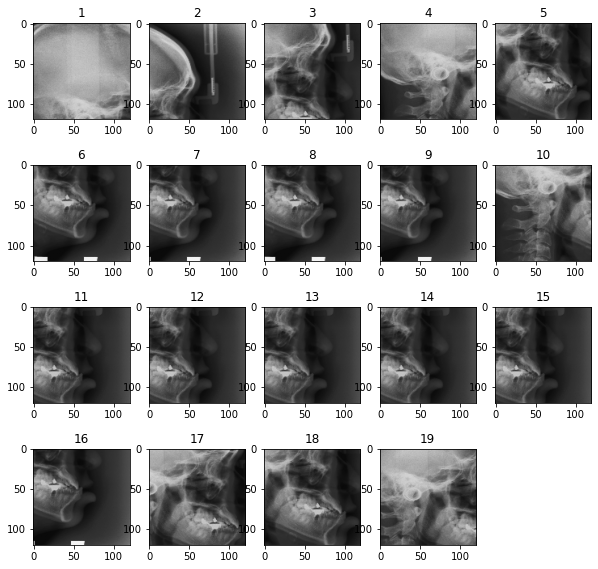

In [ ]:
# ROI for train Image number 6
plt.rcParams['figure.figsize'] = (10,10)
for i in range(19):
    plt.subplot(4,5,i+1)
    plt.imshow(train_ROIs[i][0])
    plt.title(i+1)

In [ ]:
train_ROIs_labels = np.stack((x_newtrue_list,y_newtrue_list), axis=1)
val_ROIs_labels = np.stack((val_x_newtrue_list,val_y_newtrue_list), axis=1)
test_ROIs_labels = np.stack((test_x_newtrue_list,test_y_newtrue_list), axis=1)

print(train_ROIs_labels.shape)
print(val_ROIs_labels.shape)
print(test_ROIs_labels.shape)

(19, 2, 300)
(19, 2, 50)
(19, 2, 50)


In [ ]:
train_ROIs.shape

(19, 300, 120, 120, 3)

In [ ]:
np.save('train_x_newtrue_list.npy', x_newtrue_list)
np.save('train_y_newtrue_list.npy', y_newtrue_list)

np.save('val_x_newtrue_list.npy', val_x_newtrue_list)
np.save('val_y_newtrue_list.npy', val_y_newtrue_list)

np.save('test_x_newtrue_list.npy', test_x_newtrue_list)
np.save('test_y_newtrue_list.npy', test_y_newtrue_list)

In [ ]:
np.save('train_ROIs.npy', train_ROIs)
np.save('train_ROIs_labels.npy', train_ROIs_labels)

np.save('val_ROIs.npy', val_ROIs)
np.save('val_ROIs_labels.npy', val_ROIs_labels)

np.save('test_ROIs.npy', test_ROIs)
np.save('test_ROIs_labels.npy', test_ROIs_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

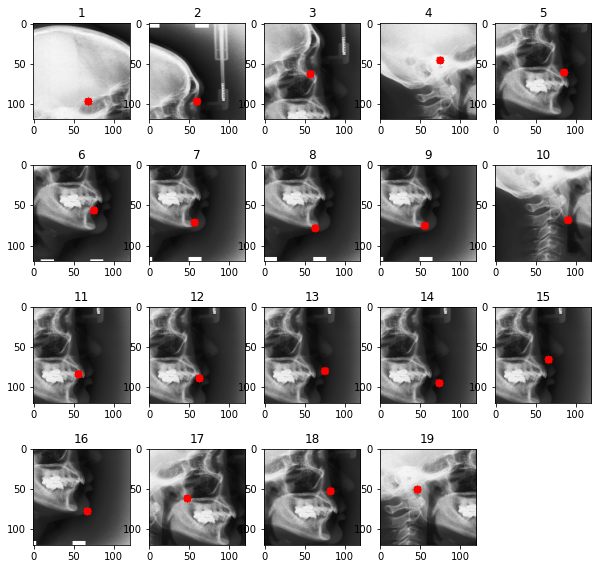

In [ ]:
# ROI for train Image number 6
plt.rcParams['figure.figsize'] = (10,10)
for i in range(19):
    img = train[i][194].copy()
    img = cv2.circle(img, (x_newtrue_list[i][194], y_newtrue_list[i][194]), 5, (255,0,0), -1)
    plt.subplot(4,5,i+1)
    plt.imshow(img)
    plt.title(i+1)